Stainless Steel Data Set
http://www.worldstainless.org/statistics/foreign_trade_stainless_scrap

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import re

from statsmodels.tsa.stattools import adfuller

from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import numpy as np
import fbprophet
from fbprophet import Prophet
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from pylab import rcParams
import datetime

import logging

from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.linear_model import LinearRegression

from sklearn import metrics

from sklearn.model_selection import ParameterGrid
from sklearn.linear_model import Ridge


logging.getLogger().setLevel(logging.ERROR)
from sklearn.preprocessing import PolynomialFeatures

from sklearn import neighbors
from sklearn.ensemble import AdaBoostRegressor

from sqlalchemy import create_engine
from sqlalchemy import(Table, Column, String, Integer, Boolean)
from sqlalchemy import MetaData, Table

import os
import matplotlib.dates as mdates

In [2]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=4).mean()
    rolstd =  pd.Series(timeseries).rolling(window=4).std()
#Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    # dftest = adfuller(timeseries, autolag='AIC')
    dftest = adfuller(timeseries)
    
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

LME_futures = pd.read_excel('forecasting_raw_data/LME Futures Price.xlsx')
LME_futures = LME_futures.iloc[3:, 1:]
#LME_futures['Unnamed: 1'] = pd.datetime(LME_futures['Unnamed: 1'])
LME_futures.index = LME_futures['Unnamed: 1']



LME_futures = LME_futures.iloc[:, 1:]
#LME_futures = LME_futures[LME_futures.index.year>=2000]
LME_futures.isnull().sum()
LME = LME_futures.iloc[:, 0]
LME = LME.astype(float)
LME = LME.resample('B').mean()


### Note About Preprocessing: 

#### For differenced data, to unscale, must concatenate the LAST VALUE OF THE ORIGINAL Y OF THE TRAINING SET, with the new PREDICTED SERIES OF SCALED_YHAT to use CUMSUM()

In [3]:
def preprocess(series, window_setting):
    moving_avg = series.rolling(window=window_setting).mean().shift()
    moving_avg_diff = series-moving_avg
    return moving_avg_diff

    

In [4]:
'''Returns unscaled y values BUT MUST ASSIGN INDEX AFTER FUNCTION! '''
def unscale(series, original_tail, window_setting):
    unscaled = []
    for key, item in series.items():
        rolling_avg = original_tail.tail(window_setting).mean()
        unscaled_result = item+rolling_avg
        original_tail = original_tail.append(pd.Series([unscaled_result]))
        unscaled.append(unscaled_result)
        
    unscaled = pd.Series(unscaled)
    unscaled = unscaled
    return unscaled

LME_shifted = LME.shift(-261).dropna()


#### Take Out Trend

Pandas time series resampling options
https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html

In [5]:

# Rolling Average from last 8 weeks
window_setting= 5*4
LME_stationary = preprocess(LME, window_setting)

rcParams['figure.figsize'] = 9, 6

#test_stationarity(LME_stationary.dropna())

LME_stationary = preprocess(LME, window_setting)

list_one = list(LME_stationary.index)
list_two = list(LME_stationary)
df = pd.DataFrame(list(zip(list_one, list_two)), columns = ['ds', 'lag0'])
df.head()

# How many lag periods? - LAG DAYS
lag_length = 20

df['lag1'] = df.lag0.shift(periods=1*lag_length)
df['lag2'] = df.lag0.shift(periods=2*lag_length)
df['lag3'] = df.lag0.shift(periods=3*lag_length)
df['lag4'] = df.lag0.shift(periods=4*lag_length)
df['lag5'] = df.lag0.shift(periods=5*lag_length)

df['lag6'] = df.lag0.shift(periods=6*lag_length)
df['lag7'] = df.lag0.shift(periods=7*lag_length)
df['lag8'] = df.lag0.shift(periods=8*lag_length)
df['lag9'] = df.lag0.shift(periods=9*lag_length)
df['lag10'] = df.lag0.shift(periods=10*lag_length)


df.index = df['ds']
df = df.iloc[:, 1:]


df['y'] = df['lag0'].shift(-261)
df = df.dropna()
df.head()

,lag0,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,lag10,y
ds,,,,,,,,,,,,
1990-11-05,-218.75,-693.00,106.25,774.75,1288.75,363.25,-673.75,-143.25,318.00,1140.00,-810.5,-39.40
1990-11-06,-168.75,-775.50,496.25,679.75,598.75,237.00,-593.75,168.00,245.50,892.50,-1018.0,-53.40
1990-11-07,-26.25,-905.50,838.75,1006.25,434.25,239.00,-612.25,520.00,234.25,628.75,-1082.5,-114.65
1990-11-08,-175.00,-1180.50,332.50,856.75,761.25,387.75,-506.00,368.50,130.25,1136.75,-562.0,-129.40
1990-11-09,-60.00,-984.25,-477.50,778.00,1018.00,436.00,-374.75,224.00,-144.00,1317.00,-448.5,-91.65


### Splitting up Training/Testing by Day

- Train multiple models on 261*16=4176 days versus Tests of 261 AND 522 days (1 and 2 years)

- Now try 70:30 training:testing ratio with 12 years training and 5 years testing --> 12*261=3132, 5*261=1305

- Next... try taking out anomoly period and training on the rest of the data - 261*10=2610


In [6]:
dates = df.index

In [31]:

results = []
datelist = []
paramlist = []

for item in dates[np.logical_or(dates.year<1996, np.logical_and(dates.year>2007, dates<'2008-10-01'))]:
    start_date = item
    train_offset = pd.tseries.offsets.BusinessDay(n=261*10)
    end_date = item+train_offset
    
    
    start_date_test = end_date + pd.tseries.offsets.BusinessDay(n=1)
    test_offset = pd.tseries.offsets.BusinessDay(n=261)
    end_date_test = start_date_test+test_offset
    train = df.loc[start_date:end_date, :]    
    test = df.loc[start_date_test:end_date_test, :]
    
    X_train = train[['lag0', 'lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10']]
    X_test = test[['lag0', 'lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10']]

    y_train = train['y']
    y_test = test['y']
    
    cv_results={}

    
    for K in range(0, 68, 2):
        K = K+1
        regressor = neighbors.KNeighborsRegressor(n_neighbors=K)

        #rint()
        #rint('K: ', K)

        regressor.fit(X_train, y_train)
        #print(regressor.coef_)

        y_pred = regressor.predict(X_test)
        y_pred = pd.Series(y_pred)
        y_pred.index = y_test.index


        original_tail = LME_shifted.loc[y_train.index[-window_setting:]]

        for key, item in y_pred.items():
            rolling_avg = original_tail.tail(window_setting).mean()
            unscaled_result = item+rolling_avg
            original_tail = original_tail.append(pd.Series([unscaled_result]))

        unscaled = pd.Series(original_tail)
        unscaled = unscaled[window_setting:]
        unscaled.index = y_test.index
        
        original_tail = LME_shifted.loc[y_train.index[-window_setting:]]

        for key, item in y_test.items():
            rolling_avg = original_tail.tail(window_setting).mean()
            original_y = item+rolling_avg
            original_tail = original_tail.append(pd.Series([original_y]))


        original_y = pd.Series(original_tail)
        original_y = original_y[window_setting:]
        original_y.index = y_test.index

        mae = metrics.mean_absolute_error(original_y, unscaled)

        #print('kfold test accuracy =', kfold_test_accuracy)
        cv_results[str(K)] = mae

        
    
    cv_results_series = pd.Series(list(cv_results.values()))
    cv_results_series.index = cv_results.keys()
    min_test_accuracy = cv_results_series.min()
    min_parameters = cv_results_series.idxmin()
    
        
    print(start_date_test,', Optimal K:' , min_parameters, ', MAE:',min_test_accuracy )
    #or key, value in cv_results.items():
        #rint(key, value)
    results.append(min_test_accuracy)
    datelist.append(start_date_test)
    paramlist.append(min_parameters)



    

2000-11-07 00:00:00 , Optimal K: 67 , MAE: 1628.4786275538281
2000-11-08 00:00:00 , Optimal K: 67 , MAE: 1641.693742363778
2000-11-09 00:00:00 , Optimal K: 67 , MAE: 1634.0759456992664
2000-11-10 00:00:00 , Optimal K: 67 , MAE: 1599.073200916261
2000-11-13 00:00:00 , Optimal K: 67 , MAE: 1499.5943952442017
2000-11-14 00:00:00 , Optimal K: 67 , MAE: 1350.9661517004595
2000-11-15 00:00:00 , Optimal K: 65 , MAE: 1261.3668290829426
2000-11-16 00:00:00 , Optimal K: 65 , MAE: 1198.4752600918325
2000-11-17 00:00:00 , Optimal K: 19 , MAE: 1115.880245526304
2000-11-20 00:00:00 , Optimal K: 11 , MAE: 1041.548846698555
2000-11-21 00:00:00 , Optimal K: 11 , MAE: 997.9114793854723
2000-11-22 00:00:00 , Optimal K: 11 , MAE: 973.0361825867708
2000-11-23 00:00:00 , Optimal K: 11 , MAE: 970.1647888002254
2000-11-24 00:00:00 , Optimal K: 21 , MAE: 971.2651767920628
2000-11-27 00:00:00 , Optimal K: 19 , MAE: 952.3701488513767
2000-11-28 00:00:00 , Optimal K: 19 , MAE: 928.407817532847
2000-11-29 00:00:00

2001-05-15 00:00:00 , Optimal K: 17 , MAE: 383.427372752266
2001-05-16 00:00:00 , Optimal K: 17 , MAE: 375.0583632745163
2001-05-17 00:00:00 , Optimal K: 9 , MAE: 369.6087256840474
2001-05-18 00:00:00 , Optimal K: 17 , MAE: 362.54594157925203
2001-05-21 00:00:00 , Optimal K: 9 , MAE: 354.71333763383547
2001-05-22 00:00:00 , Optimal K: 9 , MAE: 352.18813275608625
2001-05-23 00:00:00 , Optimal K: 9 , MAE: 354.96069626969364
2001-05-24 00:00:00 , Optimal K: 9 , MAE: 359.53438311599666
2001-05-25 00:00:00 , Optimal K: 9 , MAE: 365.2462088878517
2001-05-28 00:00:00 , Optimal K: 9 , MAE: 369.6617945726508
2001-05-29 00:00:00 , Optimal K: 9 , MAE: 372.83604742606525
2001-05-30 00:00:00 , Optimal K: 9 , MAE: 377.4075558142117
2001-05-31 00:00:00 , Optimal K: 9 , MAE: 394.06201175133623
2001-06-01 00:00:00 , Optimal K: 9 , MAE: 395.12938953726604
2001-06-04 00:00:00 , Optimal K: 9 , MAE: 402.3459951109774
2001-06-05 00:00:00 , Optimal K: 9 , MAE: 404.5211942473923
2001-06-06 00:00:00 , Optimal 

2001-11-21 00:00:00 , Optimal K: 7 , MAE: 1214.4016538625742
2001-11-22 00:00:00 , Optimal K: 7 , MAE: 1222.4781397544891
2001-11-23 00:00:00 , Optimal K: 7 , MAE: 1236.6023239607387
2001-11-26 00:00:00 , Optimal K: 7 , MAE: 1254.778969783204
2001-11-27 00:00:00 , Optimal K: 7 , MAE: 1271.8852927985413
2001-11-28 00:00:00 , Optimal K: 7 , MAE: 1279.4107039660682
2001-11-29 00:00:00 , Optimal K: 7 , MAE: 1295.281824246093
2001-11-30 00:00:00 , Optimal K: 7 , MAE: 1313.3806494069263
2001-12-03 00:00:00 , Optimal K: 7 , MAE: 1323.3595318492582
2001-12-04 00:00:00 , Optimal K: 7 , MAE: 1357.8745539818483
2001-12-05 00:00:00 , Optimal K: 7 , MAE: 1402.9451815977895
2001-12-06 00:00:00 , Optimal K: 7 , MAE: 1466.067726143464
2001-12-07 00:00:00 , Optimal K: 7 , MAE: 1518.230786806116
2001-12-10 00:00:00 , Optimal K: 7 , MAE: 1563.8333922568472
2001-12-11 00:00:00 , Optimal K: 7 , MAE: 1614.7268340340065
2001-12-12 00:00:00 , Optimal K: 7 , MAE: 1645.3786175588193
2001-12-13 00:00:00 , Optima

2002-05-30 00:00:00 , Optimal K: 1 , MAE: 3074.6111551797617
2002-05-31 00:00:00 , Optimal K: 1 , MAE: 3029.007689270396
2002-06-03 00:00:00 , Optimal K: 1 , MAE: 2907.9386980253144
2002-06-04 00:00:00 , Optimal K: 1 , MAE: 2944.7916854905548
2002-06-05 00:00:00 , Optimal K: 1 , MAE: 2888.653201808816
2002-06-06 00:00:00 , Optimal K: 1 , MAE: 2812.0161921058716
2002-06-07 00:00:00 , Optimal K: 1 , MAE: 2656.6500601554203
2002-06-10 00:00:00 , Optimal K: 1 , MAE: 2690.388897250113
2002-06-11 00:00:00 , Optimal K: 3 , MAE: 2706.937961236719
2002-06-12 00:00:00 , Optimal K: 3 , MAE: 2739.587213242257
2002-06-13 00:00:00 , Optimal K: 3 , MAE: 2796.122904698053
2002-06-14 00:00:00 , Optimal K: 1 , MAE: 2850.878707497443
2002-06-17 00:00:00 , Optimal K: 1 , MAE: 2896.2542511725946
2002-06-18 00:00:00 , Optimal K: 1 , MAE: 2907.3183762715603
2002-06-19 00:00:00 , Optimal K: 1 , MAE: 2929.0681564825495
2002-06-20 00:00:00 , Optimal K: 1 , MAE: 2951.0109562881667
2002-06-21 00:00:00 , Optimal K

2002-12-04 00:00:00 , Optimal K: 11 , MAE: 1558.3232703686463
2002-12-05 00:00:00 , Optimal K: 11 , MAE: 1535.2218659088196
2002-12-06 00:00:00 , Optimal K: 11 , MAE: 1487.016007029398
2002-12-09 00:00:00 , Optimal K: 31 , MAE: 1442.6969089194563
2002-12-10 00:00:00 , Optimal K: 31 , MAE: 1403.378740577822
2002-12-11 00:00:00 , Optimal K: 1 , MAE: 1320.9156476294113
2002-12-12 00:00:00 , Optimal K: 33 , MAE: 1319.7277769956709
2002-12-13 00:00:00 , Optimal K: 33 , MAE: 1273.138807700195
2002-12-16 00:00:00 , Optimal K: 39 , MAE: 1237.0754559186494
2002-12-17 00:00:00 , Optimal K: 39 , MAE: 1194.8398970757964
2002-12-18 00:00:00 , Optimal K: 67 , MAE: 1167.7323836193814
2002-12-19 00:00:00 , Optimal K: 67 , MAE: 1158.829311993505
2002-12-20 00:00:00 , Optimal K: 67 , MAE: 1165.2895501202447
2002-12-23 00:00:00 , Optimal K: 67 , MAE: 1195.3359041324532
2002-12-24 00:00:00 , Optimal K: 67 , MAE: 1257.7576237461276
2002-12-25 00:00:00 , Optimal K: 67 , MAE: 1348.4850377117525
2002-12-26 00

2003-06-10 00:00:00 , Optimal K: 3 , MAE: 1605.5645122639205
2003-06-11 00:00:00 , Optimal K: 3 , MAE: 1621.2769431382435
2003-06-12 00:00:00 , Optimal K: 3 , MAE: 1617.9460085275482
2003-06-13 00:00:00 , Optimal K: 3 , MAE: 1596.4802036922638
2003-06-16 00:00:00 , Optimal K: 3 , MAE: 1596.4916729894444
2003-06-17 00:00:00 , Optimal K: 3 , MAE: 1599.672429992984
2003-06-18 00:00:00 , Optimal K: 3 , MAE: 1579.4790812984606
2003-06-19 00:00:00 , Optimal K: 3 , MAE: 1547.9834631291078
2003-06-20 00:00:00 , Optimal K: 3 , MAE: 1530.7129457475776
2003-06-23 00:00:00 , Optimal K: 3 , MAE: 1554.1474639715684
2003-06-24 00:00:00 , Optimal K: 15 , MAE: 1536.163055232117
2003-06-25 00:00:00 , Optimal K: 67 , MAE: 1481.1989776417552
2003-06-26 00:00:00 , Optimal K: 67 , MAE: 1417.2560130047104
2003-06-27 00:00:00 , Optimal K: 67 , MAE: 1378.3185678229033
2003-06-30 00:00:00 , Optimal K: 67 , MAE: 1357.5943700844448
2003-07-01 00:00:00 , Optimal K: 67 , MAE: 1345.9491997234063
2003-07-02 00:00:00 

2003-12-15 00:00:00 , Optimal K: 67 , MAE: 2111.6562565362237
2003-12-16 00:00:00 , Optimal K: 67 , MAE: 2165.487696966667
2003-12-17 00:00:00 , Optimal K: 67 , MAE: 2181.7787324165993
2003-12-18 00:00:00 , Optimal K: 67 , MAE: 2192.2296154020746
2003-12-19 00:00:00 , Optimal K: 67 , MAE: 2172.200932444122
2003-12-22 00:00:00 , Optimal K: 65 , MAE: 2055.8424008291004
2003-12-23 00:00:00 , Optimal K: 1 , MAE: 1224.426575897532
2003-12-24 00:00:00 , Optimal K: 1 , MAE: 1259.0840213523386
2003-12-25 00:00:00 , Optimal K: 1 , MAE: 1304.8335365255134
2003-12-26 00:00:00 , Optimal K: 1 , MAE: 1362.6444636478368
2003-12-29 00:00:00 , Optimal K: 1 , MAE: 1373.8895608646144
2003-12-30 00:00:00 , Optimal K: 1 , MAE: 1381.799558960679
2003-12-31 00:00:00 , Optimal K: 1 , MAE: 1360.9425751552033
2004-01-01 00:00:00 , Optimal K: 1 , MAE: 1295.9989441895573
2004-01-02 00:00:00 , Optimal K: 1 , MAE: 1315.8642110480237
2004-01-05 00:00:00 , Optimal K: 65 , MAE: 1300.2330297184665
2004-01-06 00:00:00 ,

2004-06-21 00:00:00 , Optimal K: 15 , MAE: 2624.678875932173
2004-06-22 00:00:00 , Optimal K: 3 , MAE: 2605.2050742062565
2004-06-23 00:00:00 , Optimal K: 1 , MAE: 2222.3696309395427
2004-06-24 00:00:00 , Optimal K: 1 , MAE: 2141.3521875071588
2004-06-25 00:00:00 , Optimal K: 3 , MAE: 2113.158302493292
2004-06-28 00:00:00 , Optimal K: 3 , MAE: 2115.4806967793866
2004-06-29 00:00:00 , Optimal K: 3 , MAE: 2106.916985007069
2004-06-30 00:00:00 , Optimal K: 3 , MAE: 2108.9550060167994
2004-07-01 00:00:00 , Optimal K: 3 , MAE: 2122.458432199469
2004-07-02 00:00:00 , Optimal K: 3 , MAE: 2144.215141469246
2004-07-05 00:00:00 , Optimal K: 31 , MAE: 2135.0791726486063
2004-07-06 00:00:00 , Optimal K: 31 , MAE: 2143.4538672091126
2004-07-07 00:00:00 , Optimal K: 35 , MAE: 2165.0999119408075
2004-07-08 00:00:00 , Optimal K: 35 , MAE: 2193.637446242095
2004-07-09 00:00:00 , Optimal K: 39 , MAE: 2231.157350570269
2004-07-12 00:00:00 , Optimal K: 35 , MAE: 2269.697188494171
2004-07-13 00:00:00 , Opt

2004-12-27 00:00:00 , Optimal K: 67 , MAE: 10067.717274410064
2004-12-28 00:00:00 , Optimal K: 63 , MAE: 10143.361196955875
2004-12-29 00:00:00 , Optimal K: 63 , MAE: 10229.364061195378
2004-12-30 00:00:00 , Optimal K: 65 , MAE: 10322.446365728854
2004-12-31 00:00:00 , Optimal K: 65 , MAE: 10400.103431007525
2005-01-03 00:00:00 , Optimal K: 67 , MAE: 10486.005833553249
2005-01-04 00:00:00 , Optimal K: 67 , MAE: 10544.09603301651
2005-01-05 00:00:00 , Optimal K: 65 , MAE: 10584.437286546086
2005-01-06 00:00:00 , Optimal K: 63 , MAE: 10580.156600435472
2005-01-07 00:00:00 , Optimal K: 63 , MAE: 10591.336019492293
2005-01-10 00:00:00 , Optimal K: 63 , MAE: 10531.38059623845
2005-01-11 00:00:00 , Optimal K: 63 , MAE: 10491.276207948458
2005-01-12 00:00:00 , Optimal K: 63 , MAE: 10487.748720099802
2005-01-13 00:00:00 , Optimal K: 3 , MAE: 10455.593140295152
2005-01-14 00:00:00 , Optimal K: 3 , MAE: 10347.420013264005
2005-01-17 00:00:00 , Optimal K: 3 , MAE: 10292.418807956681
2005-01-18 00

2005-07-01 00:00:00 , Optimal K: 1 , MAE: 14100.318121284
2005-07-04 00:00:00 , Optimal K: 1 , MAE: 14022.460564150895
2005-07-05 00:00:00 , Optimal K: 1 , MAE: 13411.316563573939
2005-07-06 00:00:00 , Optimal K: 1 , MAE: 13381.031437148573
2005-07-07 00:00:00 , Optimal K: 1 , MAE: 12831.74903916633
2005-07-08 00:00:00 , Optimal K: 1 , MAE: 12774.164843389832
2005-07-11 00:00:00 , Optimal K: 1 , MAE: 11461.932093697835
2005-07-12 00:00:00 , Optimal K: 1 , MAE: 10266.180100436466
2005-07-13 00:00:00 , Optimal K: 1 , MAE: 10514.64325965382
2005-07-14 00:00:00 , Optimal K: 1 , MAE: 10003.487115693582
2005-07-15 00:00:00 , Optimal K: 1 , MAE: 9996.382542307743
2005-07-18 00:00:00 , Optimal K: 1 , MAE: 9994.953975330434
2005-07-19 00:00:00 , Optimal K: 1 , MAE: 10195.830573548736
2005-07-20 00:00:00 , Optimal K: 1 , MAE: 10013.176512097974
2005-07-21 00:00:00 , Optimal K: 1 , MAE: 9345.478393827441
2005-07-22 00:00:00 , Optimal K: 1 , MAE: 9291.81419056147
2005-07-25 00:00:00 , Optimal K: 1

2018-01-08 00:00:00 , Optimal K: 9 , MAE: 1562.4302284939274
2018-01-09 00:00:00 , Optimal K: 9 , MAE: 1529.5900725017518
2018-01-10 00:00:00 , Optimal K: 9 , MAE: 1484.945088774349
2018-01-11 00:00:00 , Optimal K: 9 , MAE: 1471.6818084296726
2018-01-12 00:00:00 , Optimal K: 7 , MAE: 1430.6948936083336
2018-01-15 00:00:00 , Optimal K: 9 , MAE: 1401.93700145394
2018-01-16 00:00:00 , Optimal K: 7 , MAE: 1321.9888594840747
2018-01-17 00:00:00 , Optimal K: 7 , MAE: 1302.2194767507349
2018-01-18 00:00:00 , Optimal K: 9 , MAE: 1290.7757940353908
2018-01-19 00:00:00 , Optimal K: 9 , MAE: 1271.075075146555
2018-01-22 00:00:00 , Optimal K: 9 , MAE: 1251.6575906680614
2018-01-23 00:00:00 , Optimal K: 9 , MAE: 1266.2580034803054
2018-01-24 00:00:00 , Optimal K: 11 , MAE: 1263.7009754665157
2018-01-25 00:00:00 , Optimal K: 11 , MAE: 1257.7611105775748
2018-01-26 00:00:00 , Optimal K: 11 , MAE: 1243.029547432128
2018-01-29 00:00:00 , Optimal K: 11 , MAE: 1221.908425793882
2018-01-30 00:00:00 , Opti

2018-07-13 00:00:00 , Optimal K: 3 , MAE: 2641.2940314909683
2018-07-16 00:00:00 , Optimal K: 3 , MAE: 2648.07486262957
2018-07-17 00:00:00 , Optimal K: 3 , MAE: 2578.0672212835443
2018-07-18 00:00:00 , Optimal K: 3 , MAE: 2449.7855836713534
2018-07-19 00:00:00 , Optimal K: 3 , MAE: 2281.828240442374
2018-07-20 00:00:00 , Optimal K: 3 , MAE: 2201.6009534171167
2018-07-23 00:00:00 , Optimal K: 3 , MAE: 2172.748557977151
2018-07-24 00:00:00 , Optimal K: 3 , MAE: 2188.027271356741
2018-07-25 00:00:00 , Optimal K: 3 , MAE: 2075.2779556484134
2018-07-26 00:00:00 , Optimal K: 3 , MAE: 2030.3397587212287
2018-07-27 00:00:00 , Optimal K: 3 , MAE: 2033.080445618092
2018-07-30 00:00:00 , Optimal K: 7 , MAE: 2032.1797901723464
2018-07-31 00:00:00 , Optimal K: 7 , MAE: 2025.10606856172
2018-08-01 00:00:00 , Optimal K: 7 , MAE: 1971.1632014185252
2018-08-02 00:00:00 , Optimal K: 7 , MAE: 1912.8745480860055
2018-08-03 00:00:00 , Optimal K: 7 , MAE: 1909.2947709657626
2018-08-06 00:00:00 , Optimal K:

In [32]:
df_results = pd.DataFrame({'results': results, 'K': paramlist})
df_results.index = datelist
df_results.to_csv('results_no_anomoly.csv')

### New Experiment! Where training set is continually getting larger and larger while test set window remains the same

In [444]:

offdays = 4176
train_offset = pd.tseries.offsets.BusinessDay(n=offdays)

results = []
datelist = []
paramlist = []

for item in dates[dates.year<2002]:

    start_date = dates[dates.year<2002][0]
    end_date = start_date+train_offset
    offdays = offdays+1
    train_offset = pd.tseries.offsets.BusinessDay(n=offdays)
    
    start_date_test = end_date + pd.tseries.offsets.BusinessDay(n=1)
    test_offset = pd.tseries.offsets.BusinessDay(n=261)
    end_date_test = start_date_test+test_offset
    
    train = df.loc[start_date:end_date, :]    
    test = df.loc[start_date_test:end_date_test, :]
    
    X_train = train[['lag0', 'lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10']]
    X_test = test[['lag0', 'lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10']]

    y_train = train['y']
    y_test = test['y']
    
    cv_results={}

    
    for K in range(0, 68, 2):
        K = K+1
        regressor = neighbors.KNeighborsRegressor(n_neighbors=K)

        #rint()
        #rint('K: ', K)

        regressor.fit(X_train, y_train)
        #print(regressor.coef_)

        y_pred = regressor.predict(X_test)
        y_pred = pd.Series(y_pred)
        y_pred.index = y_test.index


        original_tail = LME_shifted.loc[y_train.index[-window_setting:]]

        for key, item in y_pred.items():
            rolling_avg = original_tail.tail(window_setting).mean()
            unscaled_result = item+rolling_avg
            original_tail = original_tail.append(pd.Series([unscaled_result]))

        unscaled = pd.Series(original_tail)
        unscaled = unscaled[window_setting:]
        unscaled.index = y_test.index
        
        original_tail = LME_shifted.loc[y_train.index[-window_setting:]]

        for key, item in y_test.items():
            rolling_avg = original_tail.tail(window_setting).mean()
            original_y = item+rolling_avg
            original_tail = original_tail.append(pd.Series([original_y]))


        original_y = pd.Series(original_tail)
        original_y = original_y[window_setting:]
        original_y.index = y_test.index

        mae = metrics.mean_absolute_error(original_y, unscaled)

        #print('kfold test accuracy =', kfold_test_accuracy)
        cv_results[str(K)] = mae

        
    
    cv_results_series = pd.Series(list(cv_results.values()))
    cv_results_series.index = cv_results.keys()
    min_test_accuracy = cv_results_series.min()
    min_parameters = cv_results_series.idxmin()
    
        
    print(start_date_test,', Optimal K:' , min_parameters, ', MAE:',min_test_accuracy )
    #or key, value in cv_results.items():
        #rint(key, value)
    results.append(min_test_accuracy)
    datelist.append(start_date_test)
    paramlist.append(min_parameters)



2006-11-08 00:00:00 , Optimal K: 67 , MAE: 8550.878013372598
2006-11-09 00:00:00 , Optimal K: 23 , MAE: 8732.698221302557
2006-11-10 00:00:00 , Optimal K: 67 , MAE: 9038.608223615416
2006-11-13 00:00:00 , Optimal K: 67 , MAE: 9296.60843833526
2006-11-14 00:00:00 , Optimal K: 67 , MAE: 9529.850456987902
2006-11-15 00:00:00 , Optimal K: 25 , MAE: 9682.728088295255
2006-11-16 00:00:00 , Optimal K: 25 , MAE: 9667.067452110588
2006-11-17 00:00:00 , Optimal K: 23 , MAE: 9537.989389766057
2006-11-20 00:00:00 , Optimal K: 25 , MAE: 9201.186493380901
2006-11-21 00:00:00 , Optimal K: 25 , MAE: 8987.128559095401
2006-11-22 00:00:00 , Optimal K: 17 , MAE: 8653.003668274057
2006-11-23 00:00:00 , Optimal K: 17 , MAE: 8159.090438925876
2006-11-24 00:00:00 , Optimal K: 17 , MAE: 7809.488616481061
2006-11-27 00:00:00 , Optimal K: 3 , MAE: 7389.620031236392
2006-11-28 00:00:00 , Optimal K: 5 , MAE: 7248.130635678079
2006-11-29 00:00:00 , Optimal K: 5 , MAE: 7009.971048609114
2006-11-30 00:00:00 , Optima

2007-05-15 00:00:00 , Optimal K: 17 , MAE: 11990.25915234307
2007-05-16 00:00:00 , Optimal K: 17 , MAE: 11949.514220820907
2007-05-17 00:00:00 , Optimal K: 17 , MAE: 11913.735103097786
2007-05-18 00:00:00 , Optimal K: 17 , MAE: 11803.009212558833
2007-05-21 00:00:00 , Optimal K: 17 , MAE: 11733.625617424026
2007-05-22 00:00:00 , Optimal K: 17 , MAE: 11669.154081376377
2007-05-23 00:00:00 , Optimal K: 17 , MAE: 11455.369525200944
2007-05-24 00:00:00 , Optimal K: 17 , MAE: 10971.441708947881
2007-05-25 00:00:00 , Optimal K: 3 , MAE: 9929.347736161655
2007-05-28 00:00:00 , Optimal K: 1 , MAE: 9665.501481282354
2007-05-29 00:00:00 , Optimal K: 1 , MAE: 9530.472504485402
2007-05-30 00:00:00 , Optimal K: 3 , MAE: 8631.556675357777
2007-05-31 00:00:00 , Optimal K: 3 , MAE: 8273.672330413576
2007-06-01 00:00:00 , Optimal K: 3 , MAE: 8125.951467819039
2007-06-04 00:00:00 , Optimal K: 3 , MAE: 7941.776120631705
2007-06-05 00:00:00 , Optimal K: 3 , MAE: 7903.719736309783
2007-06-06 00:00:00 , Opt

2007-11-20 00:00:00 , Optimal K: 67 , MAE: 2388.4388174930095
2007-11-21 00:00:00 , Optimal K: 67 , MAE: 2421.5428118276104
2007-11-22 00:00:00 , Optimal K: 67 , MAE: 2473.4844862339432
2007-11-23 00:00:00 , Optimal K: 67 , MAE: 2534.214957943684
2007-11-26 00:00:00 , Optimal K: 67 , MAE: 2569.105998864055
2007-11-27 00:00:00 , Optimal K: 67 , MAE: 2616.6899722474673
2007-11-28 00:00:00 , Optimal K: 67 , MAE: 2657.9570696530836
2007-11-29 00:00:00 , Optimal K: 67 , MAE: 2714.839971474658
2007-11-30 00:00:00 , Optimal K: 67 , MAE: 2777.2851500883135
2007-12-03 00:00:00 , Optimal K: 67 , MAE: 2876.9145121960432
2007-12-04 00:00:00 , Optimal K: 67 , MAE: 2975.546502478133
2007-12-05 00:00:00 , Optimal K: 67 , MAE: 3098.9204376876787
2007-12-06 00:00:00 , Optimal K: 67 , MAE: 3200.048095145564
2007-12-07 00:00:00 , Optimal K: 67 , MAE: 3311.5342163726464
2007-12-10 00:00:00 , Optimal K: 67 , MAE: 3403.7199156807205
2007-12-11 00:00:00 , Optimal K: 67 , MAE: 3484.9395064345636
2007-12-12 00

2008-05-26 00:00:00 , Optimal K: 29 , MAE: 3000.2879679070593
2008-05-27 00:00:00 , Optimal K: 29 , MAE: 2882.7196490119654
2008-05-28 00:00:00 , Optimal K: 29 , MAE: 2792.5490921325863
2008-05-29 00:00:00 , Optimal K: 29 , MAE: 2694.835141214663
2008-05-30 00:00:00 , Optimal K: 29 , MAE: 2562.595631430011
2008-06-02 00:00:00 , Optimal K: 29 , MAE: 2380.793582149672
2008-06-03 00:00:00 , Optimal K: 29 , MAE: 2232.224367622965
2008-06-04 00:00:00 , Optimal K: 29 , MAE: 2134.3396775578094
2008-06-05 00:00:00 , Optimal K: 29 , MAE: 2001.5061122294212
2008-06-06 00:00:00 , Optimal K: 29 , MAE: 1897.5874342900192
2008-06-09 00:00:00 , Optimal K: 29 , MAE: 1836.4535448146062
2008-06-10 00:00:00 , Optimal K: 29 , MAE: 1722.6236154927956
2008-06-11 00:00:00 , Optimal K: 29 , MAE: 1638.203966859431
2008-06-12 00:00:00 , Optimal K: 25 , MAE: 1529.3102208240823
2008-06-13 00:00:00 , Optimal K: 25 , MAE: 1468.3911325467186
2008-06-16 00:00:00 , Optimal K: 27 , MAE: 1478.5758398288508
2008-06-17 00

2008-11-28 00:00:00 , Optimal K: 27 , MAE: 1541.7049845797485
2008-12-01 00:00:00 , Optimal K: 37 , MAE: 1569.9958617780592
2008-12-02 00:00:00 , Optimal K: 43 , MAE: 1601.7331314276664
2008-12-03 00:00:00 , Optimal K: 43 , MAE: 1626.399009375497
2008-12-04 00:00:00 , Optimal K: 43 , MAE: 1665.263886771745
2008-12-05 00:00:00 , Optimal K: 43 , MAE: 1707.0680742040265
2008-12-08 00:00:00 , Optimal K: 43 , MAE: 1744.2778109872384
2008-12-09 00:00:00 , Optimal K: 43 , MAE: 1771.1662916794262
2008-12-10 00:00:00 , Optimal K: 43 , MAE: 1787.9618813958
2008-12-11 00:00:00 , Optimal K: 43 , MAE: 1833.7515355594442
2008-12-12 00:00:00 , Optimal K: 43 , MAE: 1853.4980747204181
2008-12-15 00:00:00 , Optimal K: 43 , MAE: 1850.1273393312808
2008-12-16 00:00:00 , Optimal K: 43 , MAE: 1858.016535272512
2008-12-17 00:00:00 , Optimal K: 43 , MAE: 1840.393318794678
2008-12-18 00:00:00 , Optimal K: 43 , MAE: 1857.6310619018277
2008-12-19 00:00:00 , Optimal K: 43 , MAE: 1861.5863746206699
2008-12-22 00:0

2009-06-05 00:00:00 , Optimal K: 67 , MAE: 3282.9497538570586
2009-06-08 00:00:00 , Optimal K: 17 , MAE: 3468.407042830156
2009-06-09 00:00:00 , Optimal K: 67 , MAE: 3746.3760960683476
2009-06-10 00:00:00 , Optimal K: 67 , MAE: 3869.3650093424153
2009-06-11 00:00:00 , Optimal K: 67 , MAE: 4045.589894953723
2009-06-12 00:00:00 , Optimal K: 21 , MAE: 4110.655836549299
2009-06-15 00:00:00 , Optimal K: 17 , MAE: 3995.157831005512
2009-06-16 00:00:00 , Optimal K: 17 , MAE: 4007.814831633445
2009-06-17 00:00:00 , Optimal K: 17 , MAE: 4037.2335069007836
2009-06-18 00:00:00 , Optimal K: 17 , MAE: 4084.741280958835
2009-06-19 00:00:00 , Optimal K: 21 , MAE: 4133.5083099876765
2009-06-22 00:00:00 , Optimal K: 21 , MAE: 4153.035581722517
2009-06-23 00:00:00 , Optimal K: 21 , MAE: 4227.207357108856
2009-06-24 00:00:00 , Optimal K: 21 , MAE: 4254.121226297742
2009-06-25 00:00:00 , Optimal K: 3 , MAE: 4161.548573889526
2009-06-26 00:00:00 , Optimal K: 3 , MAE: 3989.347749714276
2009-06-29 00:00:00 ,

2009-12-11 00:00:00 , Optimal K: 7 , MAE: 2732.52217035113
2009-12-14 00:00:00 , Optimal K: 7 , MAE: 2681.862623613956
2009-12-15 00:00:00 , Optimal K: 7 , MAE: 2662.6503884938943
2009-12-16 00:00:00 , Optimal K: 5 , MAE: 2625.7440975652394
2009-12-17 00:00:00 , Optimal K: 5 , MAE: 2630.611937596236
2009-12-18 00:00:00 , Optimal K: 5 , MAE: 2634.818551704836
2009-12-21 00:00:00 , Optimal K: 5 , MAE: 2644.6623454900423
2009-12-22 00:00:00 , Optimal K: 5 , MAE: 2652.6301101248905
2009-12-23 00:00:00 , Optimal K: 5 , MAE: 2689.005617107142
2009-12-24 00:00:00 , Optimal K: 5 , MAE: 2718.6216252457116
2009-12-25 00:00:00 , Optimal K: 5 , MAE: 2750.4399309401633
2009-12-28 00:00:00 , Optimal K: 5 , MAE: 2789.393113889791
2009-12-29 00:00:00 , Optimal K: 5 , MAE: 2812.835275469573
2009-12-30 00:00:00 , Optimal K: 5 , MAE: 2835.5028315677096
2009-12-31 00:00:00 , Optimal K: 5 , MAE: 2853.6378799616505
2010-01-01 00:00:00 , Optimal K: 5 , MAE: 2853.309124902933
2010-01-04 00:00:00 , Optimal K: 

2010-06-21 00:00:00 , Optimal K: 7 , MAE: 2709.7413398009194
2010-06-22 00:00:00 , Optimal K: 7 , MAE: 2726.2302212067652
2010-06-23 00:00:00 , Optimal K: 7 , MAE: 2738.4113842640163
2010-06-24 00:00:00 , Optimal K: 7 , MAE: 2737.79904721689
2010-06-25 00:00:00 , Optimal K: 7 , MAE: 2765.907959979361
2010-06-28 00:00:00 , Optimal K: 7 , MAE: 2796.7162096238767
2010-06-29 00:00:00 , Optimal K: 7 , MAE: 2851.441546065239
2010-06-30 00:00:00 , Optimal K: 7 , MAE: 2944.7329984417997
2010-07-01 00:00:00 , Optimal K: 7 , MAE: 3065.3472021699904
2010-07-02 00:00:00 , Optimal K: 7 , MAE: 3201.691829401167
2010-07-05 00:00:00 , Optimal K: 7 , MAE: 3242.7419415458307
2010-07-06 00:00:00 , Optimal K: 7 , MAE: 3327.105067960988
2010-07-07 00:00:00 , Optimal K: 7 , MAE: 3435.946530690967
2010-07-08 00:00:00 , Optimal K: 7 , MAE: 3719.8382191941446
2010-07-09 00:00:00 , Optimal K: 7 , MAE: 3934.444325427467
2010-07-12 00:00:00 , Optimal K: 7 , MAE: 4028.770767660275
2010-07-13 00:00:00 , Optimal K: 

2010-12-27 00:00:00 , Optimal K: 11 , MAE: 1850.30361031474
2010-12-28 00:00:00 , Optimal K: 11 , MAE: 1857.2366955006582
2010-12-29 00:00:00 , Optimal K: 11 , MAE: 1856.5459703925717
2010-12-30 00:00:00 , Optimal K: 11 , MAE: 1864.7747022183905
2010-12-31 00:00:00 , Optimal K: 11 , MAE: 1880.253602212781
2011-01-03 00:00:00 , Optimal K: 11 , MAE: 1894.3430878051818
2011-01-04 00:00:00 , Optimal K: 11 , MAE: 1911.078691429717
2011-01-05 00:00:00 , Optimal K: 11 , MAE: 1925.2602562175398
2011-01-06 00:00:00 , Optimal K: 11 , MAE: 1933.5024736124258
2011-01-07 00:00:00 , Optimal K: 11 , MAE: 1955.3866242411125
2011-01-10 00:00:00 , Optimal K: 5 , MAE: 1971.890424872654
2011-01-11 00:00:00 , Optimal K: 7 , MAE: 1982.13890048401
2011-01-12 00:00:00 , Optimal K: 5 , MAE: 1988.5534204725172
2011-01-13 00:00:00 , Optimal K: 5 , MAE: 2039.5854984651487
2011-01-14 00:00:00 , Optimal K: 5 , MAE: 2093.527899656306
2011-01-17 00:00:00 , Optimal K: 5 , MAE: 2137.583892029033
2011-01-18 00:00:00 , O

2011-07-01 00:00:00 , Optimal K: 67 , MAE: 2390.4661539452104
2011-07-04 00:00:00 , Optimal K: 67 , MAE: 2419.44825614436
2011-07-05 00:00:00 , Optimal K: 67 , MAE: 2496.204434522163
2011-07-06 00:00:00 , Optimal K: 67 , MAE: 2540.275452436973
2011-07-07 00:00:00 , Optimal K: 1 , MAE: 2525.4619576596288
2011-07-08 00:00:00 , Optimal K: 1 , MAE: 2442.6718647465536
2011-07-11 00:00:00 , Optimal K: 67 , MAE: 2444.79292718643
2011-07-12 00:00:00 , Optimal K: 67 , MAE: 2393.990955343344
2011-07-13 00:00:00 , Optimal K: 1 , MAE: 2144.232158047899
2011-07-14 00:00:00 , Optimal K: 1 , MAE: 2155.5557854737863
2011-07-15 00:00:00 , Optimal K: 1 , MAE: 2174.729669054811
2011-07-18 00:00:00 , Optimal K: 67 , MAE: 2173.86166278231
2011-07-19 00:00:00 , Optimal K: 67 , MAE: 2143.861337438917
2011-07-20 00:00:00 , Optimal K: 67 , MAE: 2112.2557525763095
2011-07-21 00:00:00 , Optimal K: 67 , MAE: 2085.1462223265853
2011-07-22 00:00:00 , Optimal K: 67 , MAE: 2056.932508842702
2011-07-25 00:00:00 , Opti

2012-01-05 00:00:00 , Optimal K: 67 , MAE: 3962.5599253962832
2012-01-06 00:00:00 , Optimal K: 67 , MAE: 3973.4267917163834
2012-01-09 00:00:00 , Optimal K: 67 , MAE: 3963.9397330057254
2012-01-10 00:00:00 , Optimal K: 67 , MAE: 3981.9189137531935
2012-01-11 00:00:00 , Optimal K: 67 , MAE: 4032.8995229776197
2012-01-12 00:00:00 , Optimal K: 67 , MAE: 4032.41669488998
2012-01-13 00:00:00 , Optimal K: 67 , MAE: 4052.27967380255
2012-01-16 00:00:00 , Optimal K: 67 , MAE: 4040.0574937358638
2012-01-17 00:00:00 , Optimal K: 67 , MAE: 4047.803280399347
2012-01-18 00:00:00 , Optimal K: 67 , MAE: 4046.4151294234703
2012-01-19 00:00:00 , Optimal K: 67 , MAE: 4072.7586033279786
2012-01-20 00:00:00 , Optimal K: 67 , MAE: 4106.312351267257
2012-01-23 00:00:00 , Optimal K: 67 , MAE: 4129.041939259829
2012-01-24 00:00:00 , Optimal K: 67 , MAE: 4095.9372668567876
2012-01-25 00:00:00 , Optimal K: 67 , MAE: 4111.352414411548
2012-01-26 00:00:00 , Optimal K: 67 , MAE: 4091.509709502328
2012-01-27 00:00:

2012-07-11 00:00:00 , Optimal K: 5 , MAE: 1322.08603085961
2012-07-12 00:00:00 , Optimal K: 5 , MAE: 1309.5017987816218
2012-07-13 00:00:00 , Optimal K: 5 , MAE: 1306.0911448897334
2012-07-16 00:00:00 , Optimal K: 5 , MAE: 1282.9575201270268
2012-07-17 00:00:00 , Optimal K: 5 , MAE: 1271.2634067291626
2012-07-18 00:00:00 , Optimal K: 5 , MAE: 1270.2806742508692
2012-07-19 00:00:00 , Optimal K: 5 , MAE: 1271.7533344398382
2012-07-20 00:00:00 , Optimal K: 5 , MAE: 1276.7279151230712
2012-07-23 00:00:00 , Optimal K: 5 , MAE: 1281.6224743118717
2012-07-24 00:00:00 , Optimal K: 5 , MAE: 1285.9324991951332
2012-07-25 00:00:00 , Optimal K: 5 , MAE: 1295.9310561577468
2012-07-26 00:00:00 , Optimal K: 5 , MAE: 1296.7145072720848
2012-07-27 00:00:00 , Optimal K: 5 , MAE: 1289.0600838579094
2012-07-30 00:00:00 , Optimal K: 5 , MAE: 1287.6953723067418
2012-07-31 00:00:00 , Optimal K: 5 , MAE: 1252.9730420502178
2012-08-01 00:00:00 , Optimal K: 5 , MAE: 1262.339893567855
2012-08-02 00:00:00 , Optim

2013-01-16 00:00:00 , Optimal K: 7 , MAE: 2065.747200100622
2013-01-17 00:00:00 , Optimal K: 7 , MAE: 2021.6679659487909
2013-01-18 00:00:00 , Optimal K: 7 , MAE: 1996.5256666570544
2013-01-21 00:00:00 , Optimal K: 7 , MAE: 1995.2938599440893
2013-01-22 00:00:00 , Optimal K: 7 , MAE: 1970.9379208813168
2013-01-23 00:00:00 , Optimal K: 7 , MAE: 1946.3514868973004
2013-01-24 00:00:00 , Optimal K: 7 , MAE: 1927.6101255562878
2013-01-25 00:00:00 , Optimal K: 7 , MAE: 1937.0286948341777
2013-01-28 00:00:00 , Optimal K: 7 , MAE: 1946.5679774347552
2013-01-29 00:00:00 , Optimal K: 7 , MAE: 1957.6245426869475
2013-01-30 00:00:00 , Optimal K: 7 , MAE: 1967.248138204409
2013-01-31 00:00:00 , Optimal K: 7 , MAE: 2011.4147524594273
2013-02-01 00:00:00 , Optimal K: 7 , MAE: 2033.0708916902129
2013-02-04 00:00:00 , Optimal K: 7 , MAE: 2044.6878338069496
2013-02-05 00:00:00 , Optimal K: 7 , MAE: 2066.735518466404
2013-02-06 00:00:00 , Optimal K: 7 , MAE: 2094.3719110507463
2013-02-07 00:00:00 , Optim

2013-07-24 00:00:00 , Optimal K: 7 , MAE: 4688.8870525228085
2013-07-25 00:00:00 , Optimal K: 7 , MAE: 4723.364659821952
2013-07-26 00:00:00 , Optimal K: 7 , MAE: 4759.035546952763
2013-07-29 00:00:00 , Optimal K: 7 , MAE: 4732.965874960831
2013-07-30 00:00:00 , Optimal K: 1 , MAE: 4501.419406878026
2013-07-31 00:00:00 , Optimal K: 1 , MAE: 4595.7259882700855
2013-08-01 00:00:00 , Optimal K: 1 , MAE: 4574.999995798314
2013-08-02 00:00:00 , Optimal K: 1 , MAE: 4606.459094244327
2013-08-05 00:00:00 , Optimal K: 7 , MAE: 4626.54115086961
2013-08-06 00:00:00 , Optimal K: 1 , MAE: 4548.720453940103
2013-08-07 00:00:00 , Optimal K: 7 , MAE: 4597.417787394417
2013-08-08 00:00:00 , Optimal K: 11 , MAE: 4621.612528989454
2013-08-09 00:00:00 , Optimal K: 1 , MAE: 4435.930966769848
2013-08-12 00:00:00 , Optimal K: 1 , MAE: 4491.690196569069
2013-08-13 00:00:00 , Optimal K: 1 , MAE: 4606.419185313837
2013-08-14 00:00:00 , Optimal K: 1 , MAE: 4615.258553339042
2013-08-15 00:00:00 , Optimal K: 11 , 

2014-01-29 00:00:00 , Optimal K: 67 , MAE: 3355.718641567255
2014-01-30 00:00:00 , Optimal K: 67 , MAE: 3373.598803597139
2014-01-31 00:00:00 , Optimal K: 67 , MAE: 3420.2765502803327
2014-02-03 00:00:00 , Optimal K: 67 , MAE: 3476.0328200842264
2014-02-04 00:00:00 , Optimal K: 67 , MAE: 3535.321583538825
2014-02-05 00:00:00 , Optimal K: 67 , MAE: 3579.5284924379102
2014-02-06 00:00:00 , Optimal K: 67 , MAE: 3637.9867012768514
2014-02-07 00:00:00 , Optimal K: 67 , MAE: 3703.3483780013594
2014-02-10 00:00:00 , Optimal K: 67 , MAE: 3769.612315546713
2014-02-11 00:00:00 , Optimal K: 67 , MAE: 3799.205480996264
2014-02-12 00:00:00 , Optimal K: 67 , MAE: 3802.6822293593773
2014-02-13 00:00:00 , Optimal K: 67 , MAE: 3824.697836077132
2014-02-14 00:00:00 , Optimal K: 67 , MAE: 3832.3393924427787
2014-02-17 00:00:00 , Optimal K: 67 , MAE: 3857.414006083795
2014-02-18 00:00:00 , Optimal K: 67 , MAE: 3847.816391356435
2014-02-19 00:00:00 , Optimal K: 67 , MAE: 3833.820272860145
2014-02-20 00:00:

2014-08-05 00:00:00 , Optimal K: 35 , MAE: 2798.219004584924
2014-08-06 00:00:00 , Optimal K: 35 , MAE: 2765.1479522723725
2014-08-07 00:00:00 , Optimal K: 35 , MAE: 2709.5214385545446
2014-08-08 00:00:00 , Optimal K: 35 , MAE: 2641.155794373652
2014-08-11 00:00:00 , Optimal K: 35 , MAE: 2635.420779089734
2014-08-12 00:00:00 , Optimal K: 35 , MAE: 2599.211180543295
2014-08-13 00:00:00 , Optimal K: 35 , MAE: 2547.768236400505
2014-08-14 00:00:00 , Optimal K: 35 , MAE: 2502.326375449502
2014-08-15 00:00:00 , Optimal K: 35 , MAE: 2477.67856587091
2014-08-18 00:00:00 , Optimal K: 35 , MAE: 2481.506777507957
2014-08-19 00:00:00 , Optimal K: 35 , MAE: 2446.189029123154
2014-08-20 00:00:00 , Optimal K: 35 , MAE: 2417.3424359094015
2014-08-21 00:00:00 , Optimal K: 35 , MAE: 2384.9053241882407
2014-08-22 00:00:00 , Optimal K: 35 , MAE: 2325.2862464468826
2014-08-25 00:00:00 , Optimal K: 35 , MAE: 2195.861071535444
2014-08-26 00:00:00 , Optimal K: 29 , MAE: 2107.5192164140863
2014-08-27 00:00:00

2015-02-09 00:00:00 , Optimal K: 5 , MAE: 623.5699267212311
2015-02-10 00:00:00 , Optimal K: 5 , MAE: 626.9678190331218
2015-02-11 00:00:00 , Optimal K: 5 , MAE: 638.419585027735
2015-02-12 00:00:00 , Optimal K: 5 , MAE: 647.3433325036231
2015-02-13 00:00:00 , Optimal K: 5 , MAE: 648.0792388896696
2015-02-16 00:00:00 , Optimal K: 5 , MAE: 649.6540861190224
2015-02-17 00:00:00 , Optimal K: 5 , MAE: 634.384968327309
2015-02-18 00:00:00 , Optimal K: 5 , MAE: 624.8271008914561
2015-02-19 00:00:00 , Optimal K: 5 , MAE: 623.082770362318
2015-02-20 00:00:00 , Optimal K: 5 , MAE: 622.7806196872976
2015-02-23 00:00:00 , Optimal K: 5 , MAE: 619.6712870963826
2015-02-24 00:00:00 , Optimal K: 5 , MAE: 620.5261572301071
2015-02-25 00:00:00 , Optimal K: 5 , MAE: 622.027588259794
2015-02-26 00:00:00 , Optimal K: 5 , MAE: 623.8757458486706
2015-02-27 00:00:00 , Optimal K: 5 , MAE: 626.0094469701082
2015-03-02 00:00:00 , Optimal K: 5 , MAE: 617.591372529147
2015-03-03 00:00:00 , Optimal K: 5 , MAE: 618

2015-08-18 00:00:00 , Optimal K: 19 , MAE: 1141.80147314406
2015-08-19 00:00:00 , Optimal K: 19 , MAE: 1096.332345238461
2015-08-20 00:00:00 , Optimal K: 19 , MAE: 1074.9764948983648
2015-08-21 00:00:00 , Optimal K: 19 , MAE: 1058.352349875418
2015-08-24 00:00:00 , Optimal K: 19 , MAE: 1042.296934182173
2015-08-25 00:00:00 , Optimal K: 23 , MAE: 1017.3059058340825
2015-08-26 00:00:00 , Optimal K: 23 , MAE: 988.8120190921526
2015-08-27 00:00:00 , Optimal K: 23 , MAE: 944.4729524657351
2015-08-28 00:00:00 , Optimal K: 23 , MAE: 884.4924029356318
2015-08-31 00:00:00 , Optimal K: 23 , MAE: 840.6058811390739
2015-09-01 00:00:00 , Optimal K: 19 , MAE: 814.7672503951733
2015-09-02 00:00:00 , Optimal K: 23 , MAE: 804.6792472272016
2015-09-03 00:00:00 , Optimal K: 67 , MAE: 798.3595172638018
2015-09-04 00:00:00 , Optimal K: 67 , MAE: 795.1065238116623
2015-09-07 00:00:00 , Optimal K: 39 , MAE: 795.5292198623827
2015-09-08 00:00:00 , Optimal K: 67 , MAE: 797.8121814628606
2015-09-09 00:00:00 , O

2016-02-23 00:00:00 , Optimal K: 5 , MAE: 923.3550511917454
2016-02-24 00:00:00 , Optimal K: 5 , MAE: 927.1412089190637
2016-02-25 00:00:00 , Optimal K: 5 , MAE: 927.7844764786843
2016-02-26 00:00:00 , Optimal K: 5 , MAE: 940.0259714164462
2016-02-29 00:00:00 , Optimal K: 5 , MAE: 962.0426927808275
2016-03-01 00:00:00 , Optimal K: 5 , MAE: 970.1876244344404
2016-03-02 00:00:00 , Optimal K: 5 , MAE: 984.7859329470906
2016-03-03 00:00:00 , Optimal K: 5 , MAE: 981.4141889889281
2016-03-04 00:00:00 , Optimal K: 5 , MAE: 987.2577300766653
2016-03-07 00:00:00 , Optimal K: 5 , MAE: 990.3512918987528
2016-03-08 00:00:00 , Optimal K: 5 , MAE: 992.3350617977546
2016-03-09 00:00:00 , Optimal K: 5 , MAE: 992.833657801749
2016-03-10 00:00:00 , Optimal K: 5 , MAE: 993.7849984511379
2016-03-11 00:00:00 , Optimal K: 5 , MAE: 981.4235544701788
2016-03-14 00:00:00 , Optimal K: 5 , MAE: 981.2014432588279
2016-03-15 00:00:00 , Optimal K: 5 , MAE: 975.8726581975272
2016-03-16 00:00:00 , Optimal K: 5 , MAE:

2016-08-31 00:00:00 , Optimal K: 5 , MAE: 722.5883324796523
2016-09-01 00:00:00 , Optimal K: 5 , MAE: 670.9068958227407
2016-09-02 00:00:00 , Optimal K: 5 , MAE: 647.2141537245565
2016-09-05 00:00:00 , Optimal K: 7 , MAE: 642.0205155375534
2016-09-06 00:00:00 , Optimal K: 9 , MAE: 630.8970457308502
2016-09-07 00:00:00 , Optimal K: 11 , MAE: 628.365827121811
2016-09-08 00:00:00 , Optimal K: 11 , MAE: 626.860032578112
2016-09-09 00:00:00 , Optimal K: 11 , MAE: 630.4237757573735
2016-09-12 00:00:00 , Optimal K: 11 , MAE: 632.8140483874192
2016-09-13 00:00:00 , Optimal K: 11 , MAE: 636.0782747267277
2016-09-14 00:00:00 , Optimal K: 11 , MAE: 638.1225846598351
2016-09-15 00:00:00 , Optimal K: 11 , MAE: 653.8781129735256
2016-09-16 00:00:00 , Optimal K: 5 , MAE: 668.6854397065046
2016-09-19 00:00:00 , Optimal K: 5 , MAE: 672.6560440396275
2016-09-20 00:00:00 , Optimal K: 5 , MAE: 682.6915933831481
2016-09-21 00:00:00 , Optimal K: 5 , MAE: 693.517995220573
2016-09-22 00:00:00 , Optimal K: 5 ,

2017-03-09 00:00:00 , Optimal K: 31 , MAE: 1091.6672999306215
2017-03-10 00:00:00 , Optimal K: 31 , MAE: 1081.8951653647111
2017-03-13 00:00:00 , Optimal K: 31 , MAE: 1058.8925181483132
2017-03-14 00:00:00 , Optimal K: 15 , MAE: 1032.8407554260525
2017-03-15 00:00:00 , Optimal K: 1 , MAE: 943.1211999619815
2017-03-16 00:00:00 , Optimal K: 1 , MAE: 915.7942521830247
2017-03-17 00:00:00 , Optimal K: 5 , MAE: 865.6380083257607
2017-03-20 00:00:00 , Optimal K: 5 , MAE: 828.2679240901273
2017-03-21 00:00:00 , Optimal K: 9 , MAE: 811.5087296262856
2017-03-22 00:00:00 , Optimal K: 5 , MAE: 800.9342970051886
2017-03-23 00:00:00 , Optimal K: 5 , MAE: 796.9584171337933
2017-03-24 00:00:00 , Optimal K: 5 , MAE: 794.6672253200786
2017-03-27 00:00:00 , Optimal K: 5 , MAE: 795.0363837358078
2017-03-28 00:00:00 , Optimal K: 5 , MAE: 797.6538962313053
2017-03-29 00:00:00 , Optimal K: 5 , MAE: 803.6129990872065
2017-03-30 00:00:00 , Optimal K: 5 , MAE: 804.0323117682734
2017-03-31 00:00:00 , Optimal K:

2017-09-15 00:00:00 , Optimal K: 19 , MAE: 898.2570041739484
2017-09-18 00:00:00 , Optimal K: 19 , MAE: 907.4592149422101
2017-09-19 00:00:00 , Optimal K: 19 , MAE: 924.7629606647824
2017-09-20 00:00:00 , Optimal K: 15 , MAE: 943.2183993181576
2017-09-21 00:00:00 , Optimal K: 15 , MAE: 955.487597994667
2017-09-22 00:00:00 , Optimal K: 15 , MAE: 959.7486556603319
2017-09-25 00:00:00 , Optimal K: 15 , MAE: 971.2378489866519
2017-09-26 00:00:00 , Optimal K: 15 , MAE: 981.4456031229271
2017-09-27 00:00:00 , Optimal K: 15 , MAE: 993.0036956238852
2017-09-28 00:00:00 , Optimal K: 15 , MAE: 1003.3761672077491
2017-09-29 00:00:00 , Optimal K: 15 , MAE: 1016.8218968291536
2017-10-02 00:00:00 , Optimal K: 15 , MAE: 1031.0224483856377
2017-10-03 00:00:00 , Optimal K: 15 , MAE: 1045.3166392706892
2017-10-04 00:00:00 , Optimal K: 15 , MAE: 1058.9607359230126
2017-10-05 00:00:00 , Optimal K: 7 , MAE: 1073.5901657858112
2017-10-06 00:00:00 , Optimal K: 7 , MAE: 1077.8546810017026
2017-10-09 00:00:00 

In [445]:
df_results = pd.DataFrame({'results': results, 'K': paramlist})
df_results.index = datelist
#df_results.to_csv('results_cumulative_training.csv')

In [450]:
# FOR WEIGHTS = DISTANCE

results2 = []
datelist2 = []
paramlist2 = []

for item in dates[dates.year<2002]:
    start_date = item
    train_offset = pd.tseries.offsets.BusinessDay(n=4174)
    end_date = item+train_offset
    
    
    start_date_test = end_date + pd.tseries.offsets.BusinessDay(n=1) 
    test_offset = pd.tseries.offsets.BusinessDay(n=261)
    end_date_test = start_date_test+test_offset
    
    train = df.loc[start_date:end_date, :]    
    test = df.loc[start_date_test:end_date_test, :]
    
    X_train = train[['lag0', 'lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10']]
    X_test = test[['lag0', 'lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10']]

    y_train = train['y']
    y_test = test['y']
    
    cv_results={}

    
    for K in range(0, 68, 2):
        K = K+1
        regressor = neighbors.KNeighborsRegressor(n_neighbors=K, weights='distance')

        #rint()
        #rint('K: ', K)

        regressor.fit(X_train, y_train)
        #print(regressor.coef_)

        y_pred = regressor.predict(X_test)
        y_pred = pd.Series(y_pred)
        y_pred.index = y_test.index


        original_tail = LME_shifted.loc[y_train.index[-window_setting:]]

        for key, item in y_pred.items():
            rolling_avg = original_tail.tail(window_setting).mean()
            unscaled_result = item+rolling_avg
            original_tail = original_tail.append(pd.Series([unscaled_result]))

        unscaled = pd.Series(original_tail)
        unscaled = unscaled[window_setting:]
        unscaled.index = y_test.index
        
        original_tail = LME_shifted.loc[y_train.index[-window_setting:]]

        for key, item in y_test.items():
            rolling_avg = original_tail.tail(window_setting).mean()
            original_y = item+rolling_avg
            original_tail = original_tail.append(pd.Series([original_y]))


        original_y = pd.Series(original_tail)
        original_y = original_y[window_setting:]
        original_y.index = y_test.index

        mae = metrics.mean_absolute_error(original_y, unscaled)

        #print('kfold test accuracy =', kfold_test_accuracy)
        cv_results[str(K)] = mae

        
    
    cv_results_series = pd.Series(list(cv_results.values()))
    cv_results_series.index = cv_results.keys()
    min_test_accuracy = cv_results_series.min()
    min_parameters = cv_results_series.idxmin()
    
        
    print(start_date_test,', Optimal K:' , min_parameters, ', MAE:',min_test_accuracy )
    #or key, value in cv_results.items():
        #rint(key, value)
    results2.append(min_test_accuracy)
    datelist2.append(start_date_test)
    paramlist2.append(min_parameters)
    
df_results2 = pd.DataFrame({'results': results2, 'K': paramlist2})
df_results2.index = datelist2

# CHECK TO MAKE SURE DF used WAS 10 LAGS! 
# THEN SAVE!!


#df_results2.to_csv('results_weighted.csv')

2006-11-06 00:00:00 , Optimal K: 67 , MAE: 8282.908866731632
2006-11-07 00:00:00 , Optimal K: 67 , MAE: 8424.56881406883
2006-11-08 00:00:00 , Optimal K: 67 , MAE: 8570.224201400137
2006-11-09 00:00:00 , Optimal K: 67 , MAE: 8760.858863105565
2006-11-10 00:00:00 , Optimal K: 67 , MAE: 9078.39195489738
2006-11-13 00:00:00 , Optimal K: 67 , MAE: 9336.501695786428
2006-11-14 00:00:00 , Optimal K: 67 , MAE: 9560.564741643097
2006-11-15 00:00:00 , Optimal K: 25 , MAE: 9732.182642949856
2006-11-16 00:00:00 , Optimal K: 25 , MAE: 9693.77155485563
2006-11-17 00:00:00 , Optimal K: 25 , MAE: 9561.40397611146
2006-11-20 00:00:00 , Optimal K: 25 , MAE: 9209.962000775437
2006-11-21 00:00:00 , Optimal K: 25 , MAE: 9004.399720475938
2006-11-22 00:00:00 , Optimal K: 17 , MAE: 8673.300790997815
2006-11-23 00:00:00 , Optimal K: 17 , MAE: 8171.258227396835
2006-11-24 00:00:00 , Optimal K: 17 , MAE: 7796.261163709641
2006-11-27 00:00:00 , Optimal K: 3 , MAE: 7374.622344050446
2006-11-28 00:00:00 , Optimal

2007-05-14 00:00:00 , Optimal K: 17 , MAE: 12119.965041571833
2007-05-15 00:00:00 , Optimal K: 17 , MAE: 12043.160266949079
2007-05-16 00:00:00 , Optimal K: 17 , MAE: 11979.155089416228
2007-05-17 00:00:00 , Optimal K: 17 , MAE: 11925.246646554198
2007-05-18 00:00:00 , Optimal K: 17 , MAE: 11828.074186010012
2007-05-21 00:00:00 , Optimal K: 17 , MAE: 11756.317671701905
2007-05-22 00:00:00 , Optimal K: 17 , MAE: 11711.820021986316
2007-05-23 00:00:00 , Optimal K: 17 , MAE: 11484.859685932624
2007-05-24 00:00:00 , Optimal K: 17 , MAE: 10983.54597298706
2007-05-25 00:00:00 , Optimal K: 3 , MAE: 9916.673538114876
2007-05-28 00:00:00 , Optimal K: 1 , MAE: 9813.836214642954
2007-05-29 00:00:00 , Optimal K: 3 , MAE: 9560.409894888155
2007-05-30 00:00:00 , Optimal K: 3 , MAE: 8637.536196105184
2007-05-31 00:00:00 , Optimal K: 3 , MAE: 8241.643634924661
2007-06-01 00:00:00 , Optimal K: 3 , MAE: 8094.177804617627
2007-06-04 00:00:00 , Optimal K: 3 , MAE: 7932.080266390972
2007-06-05 00:00:00 , O

2007-11-19 00:00:00 , Optimal K: 67 , MAE: 2203.5288318391054
2007-11-20 00:00:00 , Optimal K: 67 , MAE: 2216.3006635717134
2007-11-21 00:00:00 , Optimal K: 67 , MAE: 2238.32372245381
2007-11-22 00:00:00 , Optimal K: 67 , MAE: 2279.4106499401537
2007-11-23 00:00:00 , Optimal K: 67 , MAE: 2334.1561424728325
2007-11-26 00:00:00 , Optimal K: 67 , MAE: 2364.231118773067
2007-11-27 00:00:00 , Optimal K: 67 , MAE: 2400.2705595303883
2007-11-28 00:00:00 , Optimal K: 67 , MAE: 2438.5812912793303
2007-11-29 00:00:00 , Optimal K: 67 , MAE: 2488.1278886465457
2007-11-30 00:00:00 , Optimal K: 67 , MAE: 2537.361238968811
2007-12-03 00:00:00 , Optimal K: 67 , MAE: 2633.553492716589
2007-12-04 00:00:00 , Optimal K: 67 , MAE: 2728.7382824639744
2007-12-05 00:00:00 , Optimal K: 67 , MAE: 2843.564663828605
2007-12-06 00:00:00 , Optimal K: 67 , MAE: 2942.6116613581207
2007-12-07 00:00:00 , Optimal K: 67 , MAE: 3037.701691092558
2007-12-10 00:00:00 , Optimal K: 67 , MAE: 3113.6846145699915
2007-12-11 00:0

2008-05-23 00:00:00 , Optimal K: 43 , MAE: 2566.9274209770215
2008-05-26 00:00:00 , Optimal K: 43 , MAE: 2510.893785834272
2008-05-27 00:00:00 , Optimal K: 43 , MAE: 2428.285907792244
2008-05-28 00:00:00 , Optimal K: 43 , MAE: 2350.27481136108
2008-05-29 00:00:00 , Optimal K: 43 , MAE: 2264.9293575375764
2008-05-30 00:00:00 , Optimal K: 43 , MAE: 2152.9344587502865
2008-06-02 00:00:00 , Optimal K: 43 , MAE: 2003.644397713662
2008-06-03 00:00:00 , Optimal K: 43 , MAE: 1884.34100744262
2008-06-04 00:00:00 , Optimal K: 43 , MAE: 1815.8141864332827
2008-06-05 00:00:00 , Optimal K: 43 , MAE: 1718.1457723242888
2008-06-06 00:00:00 , Optimal K: 43 , MAE: 1646.7901360504845
2008-06-09 00:00:00 , Optimal K: 43 , MAE: 1619.1793664415065
2008-06-10 00:00:00 , Optimal K: 27 , MAE: 1549.5627752208625
2008-06-11 00:00:00 , Optimal K: 29 , MAE: 1502.8771465189952
2008-06-12 00:00:00 , Optimal K: 23 , MAE: 1431.339638308473
2008-06-13 00:00:00 , Optimal K: 33 , MAE: 1403.2552796016582
2008-06-16 00:00

2008-11-28 00:00:00 , Optimal K: 21 , MAE: 1559.8039217869741
2008-12-01 00:00:00 , Optimal K: 65 , MAE: 1569.2676062165926
2008-12-02 00:00:00 , Optimal K: 61 , MAE: 1578.7015667961361
2008-12-03 00:00:00 , Optimal K: 61 , MAE: 1588.7623723707923
2008-12-04 00:00:00 , Optimal K: 57 , MAE: 1606.428511014513
2008-12-05 00:00:00 , Optimal K: 51 , MAE: 1628.3685059720456
2008-12-08 00:00:00 , Optimal K: 51 , MAE: 1647.8000018932735
2008-12-09 00:00:00 , Optimal K: 51 , MAE: 1668.3031966055828
2008-12-10 00:00:00 , Optimal K: 51 , MAE: 1687.261281687718
2008-12-11 00:00:00 , Optimal K: 51 , MAE: 1713.313086883273
2008-12-12 00:00:00 , Optimal K: 51 , MAE: 1736.8227698672526
2008-12-15 00:00:00 , Optimal K: 57 , MAE: 1747.67494573523
2008-12-16 00:00:00 , Optimal K: 51 , MAE: 1748.7665801842259
2008-12-17 00:00:00 , Optimal K: 39 , MAE: 1733.9031642589787
2008-12-18 00:00:00 , Optimal K: 51 , MAE: 1745.1895713458432
2008-12-19 00:00:00 , Optimal K: 39 , MAE: 1751.5899543796475
2008-12-22 00

2009-06-05 00:00:00 , Optimal K: 65 , MAE: 3268.4116437986486
2009-06-08 00:00:00 , Optimal K: 65 , MAE: 3487.414154147923
2009-06-09 00:00:00 , Optimal K: 65 , MAE: 3721.1988860693696
2009-06-10 00:00:00 , Optimal K: 65 , MAE: 3853.995375317702
2009-06-11 00:00:00 , Optimal K: 65 , MAE: 4043.0569780319984
2009-06-12 00:00:00 , Optimal K: 67 , MAE: 4140.127219312599
2009-06-15 00:00:00 , Optimal K: 65 , MAE: 4101.013871187597
2009-06-16 00:00:00 , Optimal K: 17 , MAE: 4121.446620226082
2009-06-17 00:00:00 , Optimal K: 17 , MAE: 4151.350362794696
2009-06-18 00:00:00 , Optimal K: 17 , MAE: 4184.071215138872
2009-06-19 00:00:00 , Optimal K: 3 , MAE: 4264.978827790007
2009-06-22 00:00:00 , Optimal K: 3 , MAE: 4259.709703088256
2009-06-23 00:00:00 , Optimal K: 3 , MAE: 4265.750474589515
2009-06-24 00:00:00 , Optimal K: 21 , MAE: 4304.644796714539
2009-06-25 00:00:00 , Optimal K: 3 , MAE: 4046.7651962597893
2009-06-26 00:00:00 , Optimal K: 3 , MAE: 3873.635571928062
2009-06-29 00:00:00 , Opt

2009-12-11 00:00:00 , Optimal K: 5 , MAE: 2716.9591516336263
2009-12-14 00:00:00 , Optimal K: 5 , MAE: 2653.010925156355
2009-12-15 00:00:00 , Optimal K: 5 , MAE: 2618.006862409324
2009-12-16 00:00:00 , Optimal K: 5 , MAE: 2578.9461517846357
2009-12-17 00:00:00 , Optimal K: 5 , MAE: 2571.751591687668
2009-12-18 00:00:00 , Optimal K: 5 , MAE: 2593.3522988584323
2009-12-21 00:00:00 , Optimal K: 5 , MAE: 2606.984854620887
2009-12-22 00:00:00 , Optimal K: 5 , MAE: 2615.8967587020993
2009-12-23 00:00:00 , Optimal K: 5 , MAE: 2653.638196226858
2009-12-24 00:00:00 , Optimal K: 5 , MAE: 2685.9993092121804
2009-12-25 00:00:00 , Optimal K: 5 , MAE: 2716.891359001847
2009-12-28 00:00:00 , Optimal K: 5 , MAE: 2753.410594600312
2009-12-29 00:00:00 , Optimal K: 5 , MAE: 2777.6605459777916
2009-12-30 00:00:00 , Optimal K: 5 , MAE: 2801.373229958686
2009-12-31 00:00:00 , Optimal K: 5 , MAE: 2815.1546682895123
2010-01-01 00:00:00 , Optimal K: 5 , MAE: 2815.954608515447
2010-01-04 00:00:00 , Optimal K: 

2010-06-21 00:00:00 , Optimal K: 5 , MAE: 2793.4417408727404
2010-06-22 00:00:00 , Optimal K: 5 , MAE: 2786.1123271137008
2010-06-23 00:00:00 , Optimal K: 5 , MAE: 2793.4477106101995
2010-06-24 00:00:00 , Optimal K: 5 , MAE: 2815.029976134031
2010-06-25 00:00:00 , Optimal K: 5 , MAE: 2841.5442782500218
2010-06-28 00:00:00 , Optimal K: 5 , MAE: 2890.7372335223577
2010-06-29 00:00:00 , Optimal K: 5 , MAE: 2964.9046705972773
2010-06-30 00:00:00 , Optimal K: 5 , MAE: 3081.5823731632686
2010-07-01 00:00:00 , Optimal K: 5 , MAE: 3311.077803973875
2010-07-02 00:00:00 , Optimal K: 5 , MAE: 3385.6519526490265
2010-07-05 00:00:00 , Optimal K: 5 , MAE: 3429.0248580807524
2010-07-06 00:00:00 , Optimal K: 5 , MAE: 3528.8451652110657
2010-07-07 00:00:00 , Optimal K: 5 , MAE: 3670.423503023481
2010-07-08 00:00:00 , Optimal K: 5 , MAE: 3987.7637588893344
2010-07-09 00:00:00 , Optimal K: 7 , MAE: 4234.853548739011
2010-07-12 00:00:00 , Optimal K: 5 , MAE: 4295.500485705278
2010-07-13 00:00:00 , Optimal

2010-12-27 00:00:00 , Optimal K: 11 , MAE: 2019.103886345942
2010-12-28 00:00:00 , Optimal K: 11 , MAE: 2028.387731212589
2010-12-29 00:00:00 , Optimal K: 11 , MAE: 2030.089905948753
2010-12-30 00:00:00 , Optimal K: 11 , MAE: 2040.426166945374
2010-12-31 00:00:00 , Optimal K: 11 , MAE: 2058.2968253550657
2011-01-03 00:00:00 , Optimal K: 11 , MAE: 2075.45991283085
2011-01-04 00:00:00 , Optimal K: 11 , MAE: 2095.169808015842
2011-01-05 00:00:00 , Optimal K: 11 , MAE: 2115.8231553531446
2011-01-06 00:00:00 , Optimal K: 11 , MAE: 2128.19725579636
2011-01-07 00:00:00 , Optimal K: 11 , MAE: 2155.8064234155954
2011-01-10 00:00:00 , Optimal K: 11 , MAE: 2183.2228856957277
2011-01-11 00:00:00 , Optimal K: 11 , MAE: 2213.6723295658053
2011-01-12 00:00:00 , Optimal K: 11 , MAE: 2233.5226708243276
2011-01-13 00:00:00 , Optimal K: 37 , MAE: 2317.355073173184
2011-01-14 00:00:00 , Optimal K: 37 , MAE: 2398.6543875348466
2011-01-17 00:00:00 , Optimal K: 37 , MAE: 2476.8932486234853
2011-01-18 00:00:0

2011-07-01 00:00:00 , Optimal K: 67 , MAE: 2869.7672238541386
2011-07-04 00:00:00 , Optimal K: 67 , MAE: 2922.046277060856
2011-07-05 00:00:00 , Optimal K: 67 , MAE: 3014.1040185853935
2011-07-06 00:00:00 , Optimal K: 67 , MAE: 3069.7074878697913
2011-07-07 00:00:00 , Optimal K: 67 , MAE: 3082.4967114815395
2011-07-08 00:00:00 , Optimal K: 1 , MAE: 2734.1700393487395
2011-07-11 00:00:00 , Optimal K: 1 , MAE: 2810.7762538401607
2011-07-12 00:00:00 , Optimal K: 1 , MAE: 2796.0338521337776
2011-07-13 00:00:00 , Optimal K: 1 , MAE: 2423.8027788324644
2011-07-14 00:00:00 , Optimal K: 1 , MAE: 2429.6278259344053
2011-07-15 00:00:00 , Optimal K: 1 , MAE: 2450.166800454265
2011-07-18 00:00:00 , Optimal K: 1 , MAE: 2470.899775204115
2011-07-19 00:00:00 , Optimal K: 1 , MAE: 2481.4922670508026
2011-07-20 00:00:00 , Optimal K: 1 , MAE: 2497.4533527580274
2011-07-21 00:00:00 , Optimal K: 1 , MAE: 2306.9819309950353
2011-07-22 00:00:00 , Optimal K: 1 , MAE: 2321.0920793818646
2011-07-25 00:00:00 , 

2012-01-06 00:00:00 , Optimal K: 1 , MAE: 4368.877334639529
2012-01-09 00:00:00 , Optimal K: 1 , MAE: 4326.983282529806
2012-01-10 00:00:00 , Optimal K: 1 , MAE: 4385.786854666169
2012-01-11 00:00:00 , Optimal K: 1 , MAE: 4440.280358008003
2012-01-12 00:00:00 , Optimal K: 1 , MAE: 4434.76706169108
2012-01-13 00:00:00 , Optimal K: 1 , MAE: 4513.138818179442
2012-01-16 00:00:00 , Optimal K: 1 , MAE: 4484.328967127855
2012-01-17 00:00:00 , Optimal K: 1 , MAE: 4558.0713473129645
2012-01-18 00:00:00 , Optimal K: 1 , MAE: 4715.170290003532
2012-01-19 00:00:00 , Optimal K: 67 , MAE: 4814.497078940338
2012-01-20 00:00:00 , Optimal K: 67 , MAE: 4856.881927574716
2012-01-23 00:00:00 , Optimal K: 67 , MAE: 4876.674802112796
2012-01-24 00:00:00 , Optimal K: 67 , MAE: 4832.900286930475
2012-01-25 00:00:00 , Optimal K: 67 , MAE: 4838.425410254558
2012-01-26 00:00:00 , Optimal K: 67 , MAE: 4826.328841206307
2012-01-27 00:00:00 , Optimal K: 67 , MAE: 4822.289802849796
2012-01-30 00:00:00 , Optimal K: 

2012-07-12 00:00:00 , Optimal K: 67 , MAE: 1300.726620976397
2012-07-13 00:00:00 , Optimal K: 67 , MAE: 1301.3545887398845
2012-07-16 00:00:00 , Optimal K: 67 , MAE: 1296.438287715369
2012-07-17 00:00:00 , Optimal K: 67 , MAE: 1300.1513301214934
2012-07-18 00:00:00 , Optimal K: 53 , MAE: 1307.3707724364776
2012-07-19 00:00:00 , Optimal K: 53 , MAE: 1315.293846413642
2012-07-20 00:00:00 , Optimal K: 53 , MAE: 1324.5553914660804
2012-07-23 00:00:00 , Optimal K: 53 , MAE: 1333.2348554662785
2012-07-24 00:00:00 , Optimal K: 53 , MAE: 1343.8617419552315
2012-07-25 00:00:00 , Optimal K: 53 , MAE: 1355.540754896657
2012-07-26 00:00:00 , Optimal K: 53 , MAE: 1362.570089201599
2012-07-27 00:00:00 , Optimal K: 53 , MAE: 1360.7724425566428
2012-07-30 00:00:00 , Optimal K: 53 , MAE: 1354.1009087349094
2012-07-31 00:00:00 , Optimal K: 53 , MAE: 1343.9762413932347
2012-08-01 00:00:00 , Optimal K: 53 , MAE: 1348.597930548599
2012-08-02 00:00:00 , Optimal K: 53 , MAE: 1352.7015299539705
2012-08-03 00:

2013-01-15 00:00:00 , Optimal K: 5 , MAE: 2066.3086931168973
2013-01-16 00:00:00 , Optimal K: 5 , MAE: 2049.336863451625
2013-01-17 00:00:00 , Optimal K: 5 , MAE: 2041.3183213677346
2013-01-18 00:00:00 , Optimal K: 5 , MAE: 2042.7524407637404
2013-01-21 00:00:00 , Optimal K: 5 , MAE: 2064.952428596232
2013-01-22 00:00:00 , Optimal K: 21 , MAE: 2072.471050223959
2013-01-23 00:00:00 , Optimal K: 27 , MAE: 2072.556180312743
2013-01-24 00:00:00 , Optimal K: 27 , MAE: 2079.7628469996794
2013-01-25 00:00:00 , Optimal K: 57 , MAE: 2088.010461950304
2013-01-28 00:00:00 , Optimal K: 57 , MAE: 2101.7915304740704
2013-01-29 00:00:00 , Optimal K: 57 , MAE: 2117.58832741505
2013-01-30 00:00:00 , Optimal K: 65 , MAE: 2137.236461999583
2013-01-31 00:00:00 , Optimal K: 65 , MAE: 2160.1501824668107
2013-02-01 00:00:00 , Optimal K: 57 , MAE: 2175.474070716946
2013-02-04 00:00:00 , Optimal K: 57 , MAE: 2196.0232234958407
2013-02-05 00:00:00 , Optimal K: 63 , MAE: 2216.161101651407
2013-02-06 00:00:00 , O

2013-07-24 00:00:00 , Optimal K: 1 , MAE: 5178.757374717036
2013-07-25 00:00:00 , Optimal K: 1 , MAE: 5231.9889016678635
2013-07-26 00:00:00 , Optimal K: 1 , MAE: 5283.792269774898
2013-07-29 00:00:00 , Optimal K: 1 , MAE: 5295.200158621405
2013-07-30 00:00:00 , Optimal K: 1 , MAE: 5145.0514972597475
2013-07-31 00:00:00 , Optimal K: 1 , MAE: 5240.115782198731
2013-08-01 00:00:00 , Optimal K: 1 , MAE: 5222.419129540069
2013-08-02 00:00:00 , Optimal K: 1 , MAE: 5257.476324336745
2013-08-05 00:00:00 , Optimal K: 1 , MAE: 5147.757226548294
2013-08-06 00:00:00 , Optimal K: 1 , MAE: 5043.064872544217
2013-08-07 00:00:00 , Optimal K: 1 , MAE: 5120.089905576642
2013-08-08 00:00:00 , Optimal K: 1 , MAE: 5074.5261653725465
2013-08-09 00:00:00 , Optimal K: 1 , MAE: 4798.640105540177
2013-08-12 00:00:00 , Optimal K: 1 , MAE: 4856.410556711079
2013-08-13 00:00:00 , Optimal K: 1 , MAE: 4971.359252367485
2013-08-14 00:00:00 , Optimal K: 1 , MAE: 4961.743650637443
2013-08-15 00:00:00 , Optimal K: 1 , 

2014-01-30 00:00:00 , Optimal K: 45 , MAE: 3956.9778556226333
2014-01-31 00:00:00 , Optimal K: 45 , MAE: 3999.0072696722755
2014-02-03 00:00:00 , Optimal K: 45 , MAE: 4063.4072268569694
2014-02-04 00:00:00 , Optimal K: 45 , MAE: 4103.796963580593
2014-02-05 00:00:00 , Optimal K: 45 , MAE: 4126.085385992647
2014-02-06 00:00:00 , Optimal K: 45 , MAE: 4189.478518448044
2014-02-07 00:00:00 , Optimal K: 45 , MAE: 4253.750062042068
2014-02-10 00:00:00 , Optimal K: 55 , MAE: 4308.3347965817275
2014-02-11 00:00:00 , Optimal K: 1 , MAE: 4236.993304125942
2014-02-12 00:00:00 , Optimal K: 1 , MAE: 4232.480510350785
2014-02-13 00:00:00 , Optimal K: 1 , MAE: 4253.894649933929
2014-02-14 00:00:00 , Optimal K: 1 , MAE: 4242.569365378412
2014-02-17 00:00:00 , Optimal K: 1 , MAE: 4259.497034368246
2014-02-18 00:00:00 , Optimal K: 1 , MAE: 4164.2100312048715
2014-02-19 00:00:00 , Optimal K: 1 , MAE: 4172.509119997205
2014-02-20 00:00:00 , Optimal K: 55 , MAE: 4148.243752188087
2014-02-21 00:00:00 , Opti

2014-08-06 00:00:00 , Optimal K: 3 , MAE: 3237.6061185401586
2014-08-07 00:00:00 , Optimal K: 3 , MAE: 3246.8493801940067
2014-08-08 00:00:00 , Optimal K: 3 , MAE: 3025.2697574280387
2014-08-11 00:00:00 , Optimal K: 3 , MAE: 2961.6784422205146
2014-08-12 00:00:00 , Optimal K: 3 , MAE: 2943.674935053339
2014-08-13 00:00:00 , Optimal K: 3 , MAE: 2921.216655135449
2014-08-14 00:00:00 , Optimal K: 3 , MAE: 2921.5158581911483
2014-08-15 00:00:00 , Optimal K: 3 , MAE: 2917.7425377271775
2014-08-18 00:00:00 , Optimal K: 3 , MAE: 2964.1481217030473
2014-08-19 00:00:00 , Optimal K: 3 , MAE: 2970.1704039006477
2014-08-20 00:00:00 , Optimal K: 3 , MAE: 2966.070809359762
2014-08-21 00:00:00 , Optimal K: 3 , MAE: 2928.941797815283
2014-08-22 00:00:00 , Optimal K: 3 , MAE: 2865.018548402668
2014-08-25 00:00:00 , Optimal K: 3 , MAE: 2696.0696356923963
2014-08-26 00:00:00 , Optimal K: 3 , MAE: 2584.28531526401
2014-08-27 00:00:00 , Optimal K: 3 , MAE: 2387.927332261535
2014-08-28 00:00:00 , Optimal K:

2015-02-11 00:00:00 , Optimal K: 63 , MAE: 517.6296756933864
2015-02-12 00:00:00 , Optimal K: 63 , MAE: 549.3156986107604
2015-02-13 00:00:00 , Optimal K: 63 , MAE: 575.4323180059364
2015-02-16 00:00:00 , Optimal K: 63 , MAE: 583.9173574573929
2015-02-17 00:00:00 , Optimal K: 13 , MAE: 589.180439865453
2015-02-18 00:00:00 , Optimal K: 13 , MAE: 584.9590526517555
2015-02-19 00:00:00 , Optimal K: 13 , MAE: 582.4574222902086
2015-02-20 00:00:00 , Optimal K: 13 , MAE: 580.9332805290121
2015-02-23 00:00:00 , Optimal K: 13 , MAE: 575.7816254144808
2015-02-24 00:00:00 , Optimal K: 13 , MAE: 571.6365513026931
2015-02-25 00:00:00 , Optimal K: 13 , MAE: 569.8418424269971
2015-02-26 00:00:00 , Optimal K: 13 , MAE: 570.547882591529
2015-02-27 00:00:00 , Optimal K: 13 , MAE: 571.7827131105496
2015-03-02 00:00:00 , Optimal K: 13 , MAE: 573.2635627791743
2015-03-03 00:00:00 , Optimal K: 13 , MAE: 573.1304011114757
2015-03-04 00:00:00 , Optimal K: 13 , MAE: 571.8392074058817
2015-03-05 00:00:00 , Opti

2015-08-19 00:00:00 , Optimal K: 55 , MAE: 1028.8911733501368
2015-08-20 00:00:00 , Optimal K: 57 , MAE: 966.1517918474698
2015-08-21 00:00:00 , Optimal K: 57 , MAE: 922.5540954390681
2015-08-24 00:00:00 , Optimal K: 57 , MAE: 878.488806022642
2015-08-25 00:00:00 , Optimal K: 55 , MAE: 853.7485643904188
2015-08-26 00:00:00 , Optimal K: 57 , MAE: 807.8306554128693
2015-08-27 00:00:00 , Optimal K: 49 , MAE: 752.962732776413
2015-08-28 00:00:00 , Optimal K: 55 , MAE: 690.6342438259891
2015-08-31 00:00:00 , Optimal K: 55 , MAE: 652.3286831928214
2015-09-01 00:00:00 , Optimal K: 55 , MAE: 630.788351153277
2015-09-02 00:00:00 , Optimal K: 39 , MAE: 612.9074342065857
2015-09-03 00:00:00 , Optimal K: 39 , MAE: 614.2512439279068
2015-09-04 00:00:00 , Optimal K: 39 , MAE: 614.1786853077687
2015-09-07 00:00:00 , Optimal K: 39 , MAE: 619.8779998105875
2015-09-08 00:00:00 , Optimal K: 55 , MAE: 625.1632001741642
2015-09-09 00:00:00 , Optimal K: 39 , MAE: 630.7175788228424
2015-09-10 00:00:00 , Opti

2016-02-24 00:00:00 , Optimal K: 15 , MAE: 818.670333952084
2016-02-25 00:00:00 , Optimal K: 15 , MAE: 824.8384498060811
2016-02-26 00:00:00 , Optimal K: 15 , MAE: 832.8101882613512
2016-02-29 00:00:00 , Optimal K: 13 , MAE: 844.3934697227123
2016-03-01 00:00:00 , Optimal K: 15 , MAE: 853.6276967252202
2016-03-02 00:00:00 , Optimal K: 15 , MAE: 860.9255336884786
2016-03-03 00:00:00 , Optimal K: 13 , MAE: 860.3791740338421
2016-03-04 00:00:00 , Optimal K: 13 , MAE: 865.2138621624697
2016-03-07 00:00:00 , Optimal K: 13 , MAE: 872.0456414987815
2016-03-08 00:00:00 , Optimal K: 13 , MAE: 874.8244877935608
2016-03-09 00:00:00 , Optimal K: 13 , MAE: 859.4132428484932
2016-03-10 00:00:00 , Optimal K: 15 , MAE: 846.2069452911634
2016-03-11 00:00:00 , Optimal K: 15 , MAE: 833.7845376356197
2016-03-14 00:00:00 , Optimal K: 15 , MAE: 833.08883020377
2016-03-15 00:00:00 , Optimal K: 15 , MAE: 834.2550465228038
2016-03-16 00:00:00 , Optimal K: 15 , MAE: 835.3031349766634
2016-03-17 00:00:00 , Optim

2016-09-01 00:00:00 , Optimal K: 61 , MAE: 634.7166178035359
2016-09-02 00:00:00 , Optimal K: 67 , MAE: 635.8951915041579
2016-09-05 00:00:00 , Optimal K: 67 , MAE: 645.3447336892408
2016-09-06 00:00:00 , Optimal K: 67 , MAE: 661.5820580111525
2016-09-07 00:00:00 , Optimal K: 65 , MAE: 684.0105276086625
2016-09-08 00:00:00 , Optimal K: 65 , MAE: 709.17339490401
2016-09-09 00:00:00 , Optimal K: 65 , MAE: 723.3623568874522
2016-09-12 00:00:00 , Optimal K: 65 , MAE: 740.9262451731332
2016-09-13 00:00:00 , Optimal K: 65 , MAE: 763.2191775282911
2016-09-14 00:00:00 , Optimal K: 65 , MAE: 752.2393755207773
2016-09-15 00:00:00 , Optimal K: 65 , MAE: 740.8526337526524
2016-09-16 00:00:00 , Optimal K: 65 , MAE: 729.3049804480802
2016-09-19 00:00:00 , Optimal K: 65 , MAE: 726.0815840351117
2016-09-20 00:00:00 , Optimal K: 65 , MAE: 720.3818654365094
2016-09-21 00:00:00 , Optimal K: 65 , MAE: 719.8027274464653
2016-09-22 00:00:00 , Optimal K: 65 , MAE: 715.6989419067392
2016-09-23 00:00:00 , Opti

2017-03-09 00:00:00 , Optimal K: 1 , MAE: 1261.91522063103
2017-03-10 00:00:00 , Optimal K: 7 , MAE: 1275.2310886990265
2017-03-13 00:00:00 , Optimal K: 7 , MAE: 1229.9780948349378
2017-03-14 00:00:00 , Optimal K: 3 , MAE: 1114.1797345185023
2017-03-15 00:00:00 , Optimal K: 1 , MAE: 958.6001599450395
2017-03-16 00:00:00 , Optimal K: 1 , MAE: 928.0590647023593
2017-03-17 00:00:00 , Optimal K: 1 , MAE: 851.7380406877585
2017-03-20 00:00:00 , Optimal K: 1 , MAE: 837.9194921205141
2017-03-21 00:00:00 , Optimal K: 7 , MAE: 812.2981644838204
2017-03-22 00:00:00 , Optimal K: 7 , MAE: 803.6564465895474
2017-03-23 00:00:00 , Optimal K: 7 , MAE: 790.0997804869835
2017-03-24 00:00:00 , Optimal K: 7 , MAE: 780.135608719274
2017-03-27 00:00:00 , Optimal K: 7 , MAE: 779.5233585191601
2017-03-28 00:00:00 , Optimal K: 7 , MAE: 781.5278634605929
2017-03-29 00:00:00 , Optimal K: 7 , MAE: 782.1664206746104
2017-03-30 00:00:00 , Optimal K: 7 , MAE: 782.5467058521205
2017-03-31 00:00:00 , Optimal K: 7 , MA

2017-09-18 00:00:00 , Optimal K: 7 , MAE: 862.0762804776839
2017-09-19 00:00:00 , Optimal K: 7 , MAE: 852.6566246399707
2017-09-20 00:00:00 , Optimal K: 7 , MAE: 860.2300285310578
2017-09-21 00:00:00 , Optimal K: 7 , MAE: 867.2944159854492
2017-09-22 00:00:00 , Optimal K: 7 , MAE: 891.3449601496019
2017-09-25 00:00:00 , Optimal K: 7 , MAE: 898.2722497654646
2017-09-26 00:00:00 , Optimal K: 7 , MAE: 907.5505038511276
2017-09-27 00:00:00 , Optimal K: 7 , MAE: 913.5331476324226
2017-09-28 00:00:00 , Optimal K: 7 , MAE: 906.4563865351536
2017-09-29 00:00:00 , Optimal K: 7 , MAE: 902.5726809874492
2017-10-02 00:00:00 , Optimal K: 5 , MAE: 899.349925810607
2017-10-03 00:00:00 , Optimal K: 7 , MAE: 898.7006862301866
2017-10-04 00:00:00 , Optimal K: 7 , MAE: 904.1071359704688
2017-10-05 00:00:00 , Optimal K: 7 , MAE: 902.0961316109705
2017-10-06 00:00:00 , Optimal K: 7 , MAE: 903.8781563606416
2017-10-09 00:00:00 , Optimal K: 7 , MAE: 906.5682382531146
2017-10-10 00:00:00 , Optimal K: 7 , MAE:

In [451]:
df_results2.to_csv('results_weighted.csv')

In [419]:
#df_results = pd.DataFrame({'results': results, 'K': paramlist})
#df_results.index = datelist
#df_results['results'].mean()

df_results = pd.read_csv('results_16years.csv')
df_results.index = df_results['Unnamed: 0']
df_results = df_results.iloc[:, 1:]
df_results

,results,K
Unnamed: 0,,
2006-11-06,8249.809407,23
2006-11-07,8405.595221,67
2006-11-08,8550.478951,67
2006-11-09,8734.672011,67
2006-11-10,9032.324878,25
2006-11-13,9294.864122,67
2006-11-14,9527.771229,67
2006-11-15,9672.449114,25
2006-11-16,9646.930472,25


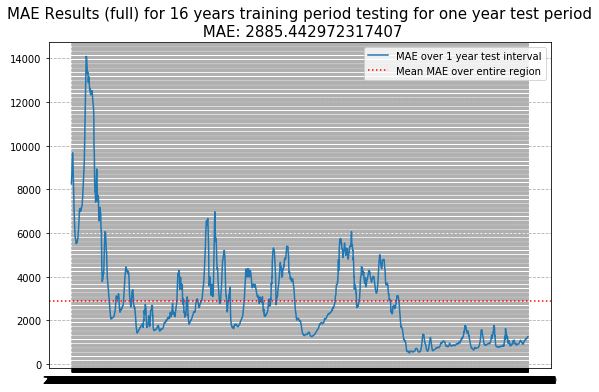

In [421]:
plt.plot(df_results['results'])
plt.title('MAE Results (full) for 16 years training period testing for one year test period\n ' + 'MAE: '+ str(df_results['results'].mean()), fontsize=15)
plt.axhline(df_results['results'].mean(), color='r', linestyle='dotted')
plt.legend(['MAE over 1 year test interval', 'Mean MAE over entire region'])
plt.grid(linestyle='dashed')


filename = 'results/KNN_16yr_train-1yr_test.png'
plt.savefig(filename)
plt.show()

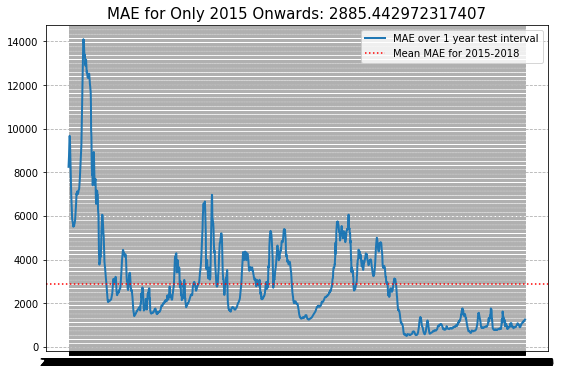

In [422]:
df_results2 = df_results[df_results.index.year>2014]
print('MAE for 2015-2018 testing:', df_results2['results'].mean())

plt.plot(df_results2['results'], linewidth=2)
plt.grid(linestyle='dashed')
plt.title('MAE for Only 2015 Onwards: ' + str(df_results2['results'].mean()), fontsize=15)
plt.axhline(df_results2['results'].mean(), color='red', linestyle='dotted')
plt.legend(['MAE over 1 year test interval', 'Mean MAE for 2015-2018'])

filename = 'results/KNN_16yr_train-1yr_test_from_2015.png'
plt.savefig(filename)

plt.show()

TO TRANSFORM

https://stackoverflow.com/questions/38058774/scikit-learn-how-to-scale-back-the-y-predicted-result


https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler.inverse_transform

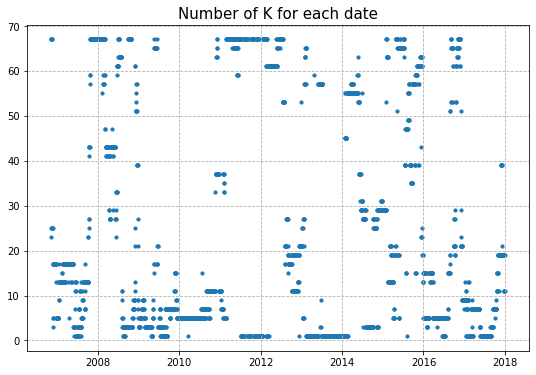

In [337]:
df_results['K']=pd.to_numeric(df_results['K'])
plt.scatter( df_results.index, df_results['K'], s=10)
plt.title('Number of K for each date', fontsize=15)
plt.grid(linestyle='dashed')

plt.show()

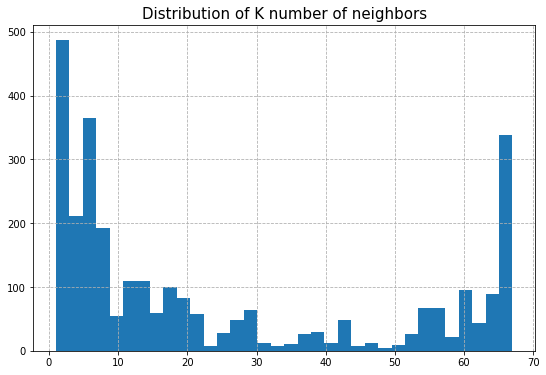

In [338]:
plt.hist(df_results['K'], 34)
plt.title('Distribution of K number of neighbors', fontsize=15)
plt.grid(linestyle='dashed')

plt.show()

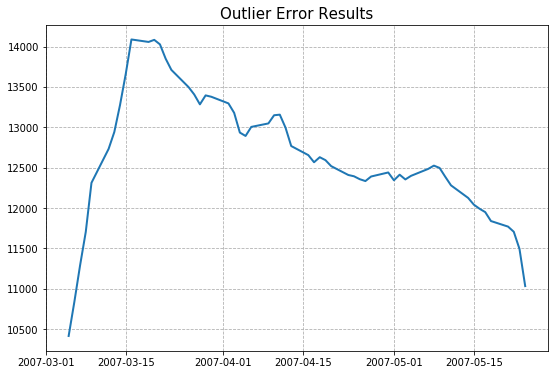

                 results   K
2007-03-05  10414.909282  13
2007-03-06  10837.496240  13
2007-03-07  11288.575978  13
2007-03-08  11704.707177  13
2007-03-09  12312.415977  13
2007-03-12  12731.989958  13
2007-03-13  12941.239149  13
2007-03-14  13275.363323  17
2007-03-15  13659.093496  17
2007-03-16  14087.981370  17
2007-03-19  14057.308300  17
2007-03-20  14083.053851  17
2007-03-21  14027.138778  17
2007-03-22  13849.602386  17
2007-03-23  13710.961925  17
2007-03-26  13498.889478  17
2007-03-27  13406.859199  17
2007-03-28  13284.105428  17
2007-03-29  13395.287210  17
2007-03-30  13378.172037  17
2007-04-02  13296.054743  17
2007-04-03  13178.877347  17
2007-04-04  12934.532453  17
2007-04-05  12892.689353  17
2007-04-06  13004.743396  17
2007-04-09  13047.848298  17
2007-04-10  13149.287618  13
2007-04-11  13156.518477  17
2007-04-12  12995.707745  17
2007-04-13  12767.920743  17
2007-04-16  12655.078177  17
2007-04-17  12567.028488   5
2007-04-18  12629.492600  17
2007-04-19  12

In [339]:
plt.plot(df_results[df_results['results']>10000]['results'], linewidth=2)
plt.title('Outlier Error Results', fontsize=15)
plt.grid(linestyle='dashed')

plt.show()

print(df_results[df_results['results']>10000])

### Notes

Testing periods beginning March 2007 through May 2007 had a really large error rate (over $10000 error off)

Let's take a look at this window in the original data

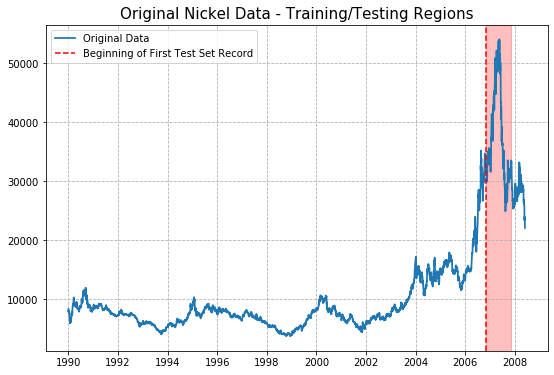

In [340]:
#plt.plot(LME.loc['2007-03-01':'2008-05-29'], linewidth=1.75)
plt.plot(LME.loc[:'2008-05-29'], linewidth=1.75)

test_start_date = datetime.datetime(2006,11,6)
test_end_date= datetime.datetime(2007, 11, 6)
plt.axvline(test_start_date, linestyle='dashed', color='red')
#plt.axvline(test_end_date, linestyle='dashed', color='green')
plt.axvspan(test_start_date, test_end_date, alpha=0.25, color='red')

plt.legend(['Original Data', 'Beginning of First Test Set Record'])
plt.grid(linestyle='dashed')

plt.title('Original Nickel Data - Training/Testing Regions', fontsize=15)
plt.show()


### We can see the source of the large MAE errors (ie MAE over 10000) is due to the sharp rise in Nickel costs between 2006 and 2007. 

It would be difficult to capture the model's performance on handling these outliers because there is not enough data to training the data leading up to it... 

Also KNN is not great for dealing with outliers. 

### So what happens if we exclude this data and only consider 

In [357]:
df_results2 = df_results[df_results.index.year>2007]
print('MAE for 2008-2018 testing:', df_results2['results'].mean())

df_results2 = df_results[df_results.index.year>2014]
print('MAE for 2015-2018 testing:', df_results2['results'].mean())


MAE for 2008-2018 testing: 2415.1265928486514
MAE for 2015-2018 testing: 923.5747109355794


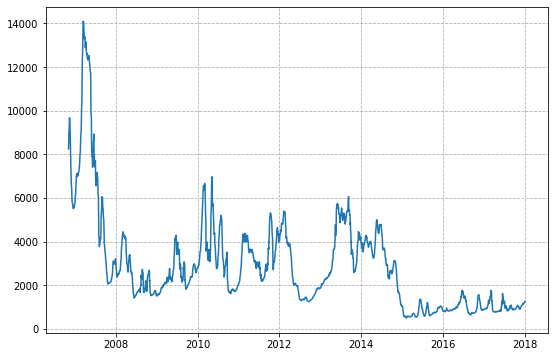

In [358]:
plt.plot(df_results['results'])
plt.grid(linestyle='dashed')

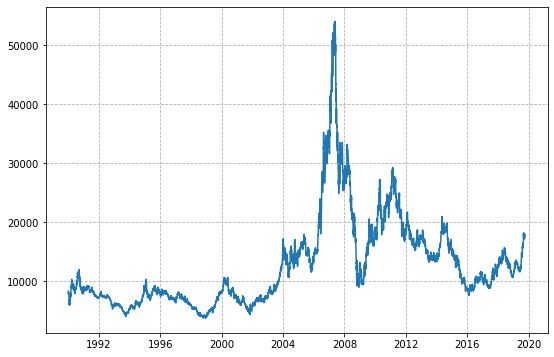

In [305]:
plt.plot(LME)
plt.grid(linestyle='dashed')

### NEXT: What happens if you redo the experiment but for a smaller number of years in training to testing ratio? (ex: train 5 years test 1st year. 

In [371]:
261*5

1305

In [ ]:
results = []
datelist = []
paramlist = []

for item in dates[dates<datetime.datetime(2012,10,1)]:
    start_date = item
    train_offset = pd.tseries.offsets.BusinessDay(n=1304)
    end_date = item+train_offset
    
    
    start_date_test = end_date + pd.tseries.offsets.BusinessDay(n=1)
    test_offset = pd.tseries.offsets.BusinessDay(n=261)
    end_date_test = start_date_test+test_offset
    
    train = df.loc[start_date:end_date, :]    
    test = df.loc[start_date_test:end_date_test, :]
    
    X_train = train[['lag0', 'lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10']]
    X_test = test[['lag0', 'lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10']]

    y_train = train['y']
    y_test = test['y']
    
    cv_results={}

    
    for K in range(0, 68, 2):
        K = K+1
        regressor = neighbors.KNeighborsRegressor(n_neighbors=K)

        regressor.fit(X_train, y_train)
        #print(regressor.coef_)

        y_pred = regressor.predict(X_test)
        y_pred = pd.Series(y_pred)
        y_pred.index = y_test.index


        original_tail = LME_shifted.loc[y_train.index[-window_setting:]]

        for key, item in y_pred.items():
            rolling_avg = original_tail.tail(window_setting).mean()
            unscaled_result = item+rolling_avg
            original_tail = original_tail.append(pd.Series([unscaled_result]))

        unscaled = pd.Series(original_tail)
        unscaled = unscaled[window_setting:]
        unscaled.index = y_test.index
        
        original_tail = LME_shifted.loc[y_train.index[-window_setting:]]

        for key, item in y_test.items():
            rolling_avg = original_tail.tail(window_setting).mean()
            original_y = item+rolling_avg
            original_tail = original_tail.append(pd.Series([original_y]))


        original_y = pd.Series(original_tail)
        original_y = original_y[window_setting:]
        original_y.index = y_test.index

        mae = metrics.mean_absolute_error(original_y, unscaled)

        #print('kfold test accuracy =', kfold_test_accuracy)
        cv_results[str(K)] = mae

        
    
    cv_results_series = pd.Series(list(cv_results.values()))
    cv_results_series.index = cv_results.keys()
    min_test_accuracy = cv_results_series.min()
    min_parameters = cv_results_series.idxmin()
    
        
    print(start_date_test,', Optimal K:' , min_parameters, ', MAE:',min_test_accuracy )
    #or key, value in cv_results.items():
        #rint(key, value)
    results.append(min_test_accuracy)
    datelist.append(start_date_test)
    paramlist.append(min_parameters)
    

In [392]:
#df_results = pd.DataFrame({'results': results, 'K': paramlist})
#df_results.index = datelist
#df_results.to_csv('results5yearrr.csv')

In [404]:
results5 = pd.read_csv('results5yearrr.csv')
results5.index = results5['Unnamed: 0']
results5 = results5.iloc[:, 1:]
results5.head()


,results,K
Unnamed: 0,,
1995-11-06,489.540170,67
1995-11-07,495.012747,67
1995-11-08,500.270550,67
1995-11-09,506.417366,67
1995-11-10,513.147857,67


In [ ]:
ax.plot('date', 'adj_close', data=data)

plt.plot(results5['results'])

plt.xaxis.set_major_locator(years)
plt.xaxis.set_major_formatter(years_fmt)
plt.xaxis.set_minor_locator(months)


plt.show()

In [407]:
results5.K.mean()

29.09413823272091

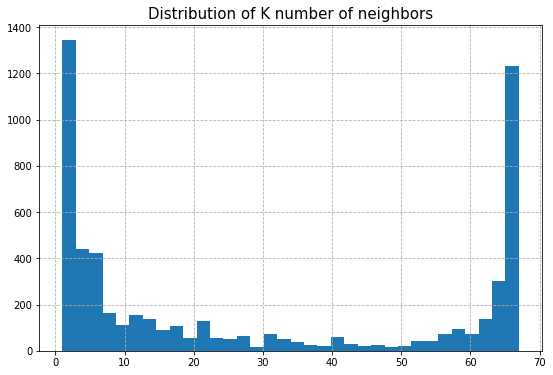

In [409]:
plt.hist(results5['K'], 34)
plt.title('Distribution of K number of neighbors', fontsize=15)
plt.grid(linestyle='dashed')

plt.show()

# Next Evaluation: For 2 Year Gaps for Target Variable, how will the results change?? 

Question... Can you still set testing range for one year even though target variable lag is 2 years long? ...Yes....



In [393]:
window_setting= 5*4
LME_stationary = preprocess(LME, window_setting)

rcParams['figure.figsize'] = 9, 6

#test_stationarity(LME_stationary.dropna())

LME_stationary = preprocess(LME, window_setting)

list_one = list(LME_stationary.index)
list_two = list(LME_stationary)
df = pd.DataFrame(list(zip(list_one, list_two)), columns = ['ds', 'lag0'])
df.head()

# How many lag periods? - LAG DAYS
lag_length = 20

df['lag1'] = df.lag0.shift(periods=1*lag_length)
df['lag2'] = df.lag0.shift(periods=2*lag_length)
df['lag3'] = df.lag0.shift(periods=3*lag_length)
df['lag4'] = df.lag0.shift(periods=4*lag_length)
df['lag5'] = df.lag0.shift(periods=5*lag_length)

df['lag6'] = df.lag0.shift(periods=6*lag_length)
df['lag7'] = df.lag0.shift(periods=7*lag_length)
df['lag8'] = df.lag0.shift(periods=8*lag_length)
df['lag9'] = df.lag0.shift(periods=9*lag_length)
df['lag10'] = df.lag0.shift(periods=10*lag_length)

df.index = df['ds']
df = df.iloc[:, 1:]

# NEW SETTING IS FOR 2 YEARS AHEAD
df['y'] = df['lag0'].shift(-522)
df = df.dropna()
df.head()

,lag0,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,lag10,y
ds,,,,,,,,,,,,
1990-11-05,-218.75,-693.00,106.25,774.75,1288.75,363.25,-673.75,-143.25,318.00,1140.00,-810.5,-338.45
1990-11-06,-168.75,-775.50,496.25,679.75,598.75,237.00,-593.75,168.00,245.50,892.50,-1018.0,-365.35
1990-11-07,-26.25,-905.50,838.75,1006.25,434.25,239.00,-612.25,520.00,234.25,628.75,-1082.5,-543.40
1990-11-08,-175.00,-1180.50,332.50,856.75,761.25,387.75,-506.00,368.50,130.25,1136.75,-562.0,-646.90
1990-11-09,-60.00,-984.25,-477.50,778.00,1018.00,436.00,-374.75,224.00,-144.00,1317.00,-448.5,-442.15


## Testing Again for 5 Years to 1 Year Train/Test ratio

In [396]:
results2 = []
datelist2 = []
paramlist2 = []

for item in dates[dates<datetime.datetime(2011,10,1)]:
    start_date = item
    train_offset = pd.tseries.offsets.BusinessDay(n=1304)
    end_date = item+train_offset
    
    
    start_date_test = end_date + pd.tseries.offsets.BusinessDay(n=1)
    test_offset = pd.tseries.offsets.BusinessDay(n=261)
    end_date_test = start_date_test+test_offset
    
    train = df.loc[start_date:end_date, :]    
    test = df.loc[start_date_test:end_date_test, :]
    
    X_train = train[['lag0', 'lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10']]
    X_test = test[['lag0', 'lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10']]

    y_train = train['y']
    y_test = test['y']
    
    cv_results={}

    
    for K in range(0, 68, 2):
        K = K+1
        regressor = neighbors.KNeighborsRegressor(n_neighbors=K)

        regressor.fit(X_train, y_train)
        #print(regressor.coef_)

        y_pred = regressor.predict(X_test)
        y_pred = pd.Series(y_pred)
        y_pred.index = y_test.index


        original_tail = LME_shifted.loc[y_train.index[-window_setting:]]

        for key, item in y_pred.items():
            rolling_avg = original_tail.tail(window_setting).mean()
            unscaled_result = item+rolling_avg
            original_tail = original_tail.append(pd.Series([unscaled_result]))

        unscaled = pd.Series(original_tail)
        unscaled = unscaled[window_setting:]
        unscaled.index = y_test.index
        
        original_tail = LME_shifted.loc[y_train.index[-window_setting:]]

        for key, item in y_test.items():
            rolling_avg = original_tail.tail(window_setting).mean()
            original_y = item+rolling_avg
            original_tail = original_tail.append(pd.Series([original_y]))


        original_y = pd.Series(original_tail)
        original_y = original_y[window_setting:]
        original_y.index = y_test.index

        mae = metrics.mean_absolute_error(original_y, unscaled)

        #print('kfold test accuracy =', kfold_test_accuracy)
        cv_results[str(K)] = mae

        
    
    cv_results_series = pd.Series(list(cv_results.values()))
    cv_results_series.index = cv_results.keys()
    min_test_accuracy = cv_results_series.min()
    min_parameters = cv_results_series.idxmin()
    
        
    print(start_date_test,', Optimal K:' , min_parameters, ', MAE:',min_test_accuracy )
    #or key, value in cv_results.items():
        #rint(key, value)
    results2.append(min_test_accuracy)
    datelist2.append(start_date_test)
    paramlist2.append(min_parameters)
    

1995-11-06 00:00:00 , Optimal K: 1 , MAE: 905.0477996732543
1995-11-07 00:00:00 , Optimal K: 1 , MAE: 901.0470345931833
1995-11-08 00:00:00 , Optimal K: 1 , MAE: 905.8063430694966
1995-11-09 00:00:00 , Optimal K: 1 , MAE: 915.9495895785973
1995-11-10 00:00:00 , Optimal K: 1 , MAE: 925.0445717420853
1995-11-13 00:00:00 , Optimal K: 1 , MAE: 930.9596746057078
1995-11-14 00:00:00 , Optimal K: 1 , MAE: 977.2099293186881
1995-11-15 00:00:00 , Optimal K: 1 , MAE: 982.4044065551348
1995-11-16 00:00:00 , Optimal K: 1 , MAE: 996.4571761972958
1995-11-17 00:00:00 , Optimal K: 1 , MAE: 997.1966096179854
1995-11-20 00:00:00 , Optimal K: 1 , MAE: 990.7032186336124
1995-11-21 00:00:00 , Optimal K: 1 , MAE: 998.9500879906816
1995-11-22 00:00:00 , Optimal K: 1 , MAE: 1011.9531578753323
1995-11-23 00:00:00 , Optimal K: 1 , MAE: 1033.4293860901637
1995-11-24 00:00:00 , Optimal K: 1 , MAE: 1051.3658287038065
1995-11-27 00:00:00 , Optimal K: 1 , MAE: 1049.630922229979
1995-11-28 00:00:00 , Optimal K: 1 , 

1996-05-14 00:00:00 , Optimal K: 1 , MAE: 1213.4603880934408
1996-05-15 00:00:00 , Optimal K: 1 , MAE: 1163.0780942248082
1996-05-16 00:00:00 , Optimal K: 1 , MAE: 1042.4628608674582
1996-05-17 00:00:00 , Optimal K: 1 , MAE: 1033.7331433704226
1996-05-20 00:00:00 , Optimal K: 1 , MAE: 1028.9080882824442
1996-05-21 00:00:00 , Optimal K: 1 , MAE: 963.2492411752959
1996-05-22 00:00:00 , Optimal K: 1 , MAE: 841.9197001133559
1996-05-23 00:00:00 , Optimal K: 1 , MAE: 845.8203681504053
1996-05-24 00:00:00 , Optimal K: 1 , MAE: 808.3580669362949
1996-05-27 00:00:00 , Optimal K: 1 , MAE: 730.5116994271954
1996-05-28 00:00:00 , Optimal K: 1 , MAE: 709.3163039923047
1996-05-29 00:00:00 , Optimal K: 1 , MAE: 702.6008960656078
1996-05-30 00:00:00 , Optimal K: 1 , MAE: 706.3760852842851
1996-05-31 00:00:00 , Optimal K: 1 , MAE: 709.6665558167819
1996-06-03 00:00:00 , Optimal K: 1 , MAE: 704.8106606080181
1996-06-04 00:00:00 , Optimal K: 1 , MAE: 709.6234138100408
1996-06-05 00:00:00 , Optimal K: 1 

1996-11-19 00:00:00 , Optimal K: 39 , MAE: 1059.6686072217612
1996-11-20 00:00:00 , Optimal K: 39 , MAE: 1054.0760610009904
1996-11-21 00:00:00 , Optimal K: 31 , MAE: 1052.1506585548432
1996-11-22 00:00:00 , Optimal K: 31 , MAE: 1051.28292410255
1996-11-25 00:00:00 , Optimal K: 31 , MAE: 1062.172522486778
1996-11-26 00:00:00 , Optimal K: 31 , MAE: 1066.3876796830366
1996-11-27 00:00:00 , Optimal K: 31 , MAE: 1070.1133060636696
1996-11-28 00:00:00 , Optimal K: 29 , MAE: 1069.6663362792622
1996-11-29 00:00:00 , Optimal K: 29 , MAE: 1071.7309308057338
1996-12-02 00:00:00 , Optimal K: 15 , MAE: 1071.8190609287326
1996-12-03 00:00:00 , Optimal K: 17 , MAE: 1087.6046036788302
1996-12-04 00:00:00 , Optimal K: 17 , MAE: 1100.464110376386
1996-12-05 00:00:00 , Optimal K: 17 , MAE: 1116.5158424880046
1996-12-06 00:00:00 , Optimal K: 15 , MAE: 1146.7471482937956
1996-12-09 00:00:00 , Optimal K: 19 , MAE: 1187.9008011657133
1996-12-10 00:00:00 , Optimal K: 15 , MAE: 1219.1478988731792
1996-12-11 0

1997-05-26 00:00:00 , Optimal K: 29 , MAE: 2188.441410356762
1997-05-27 00:00:00 , Optimal K: 29 , MAE: 2243.1354041204063
1997-05-28 00:00:00 , Optimal K: 33 , MAE: 2325.824324855715
1997-05-29 00:00:00 , Optimal K: 33 , MAE: 2433.9173890089037
1997-05-30 00:00:00 , Optimal K: 55 , MAE: 2544.605935958486
1997-06-02 00:00:00 , Optimal K: 55 , MAE: 2610.027688814668
1997-06-03 00:00:00 , Optimal K: 55 , MAE: 2686.409992642306
1997-06-04 00:00:00 , Optimal K: 55 , MAE: 2742.0694747747575
1997-06-05 00:00:00 , Optimal K: 55 , MAE: 2786.3795693273655
1997-06-06 00:00:00 , Optimal K: 33 , MAE: 2811.2715857243966
1997-06-09 00:00:00 , Optimal K: 27 , MAE: 2798.4001394072166
1997-06-10 00:00:00 , Optimal K: 27 , MAE: 2789.160185592905
1997-06-11 00:00:00 , Optimal K: 27 , MAE: 2791.5552132332236
1997-06-12 00:00:00 , Optimal K: 27 , MAE: 2776.3012937384597
1997-06-13 00:00:00 , Optimal K: 27 , MAE: 2741.331095568148
1997-06-16 00:00:00 , Optimal K: 27 , MAE: 2732.6626673876885
1997-06-17 00:0

1997-11-28 00:00:00 , Optimal K: 67 , MAE: 1099.4724301186102
1997-12-01 00:00:00 , Optimal K: 67 , MAE: 1105.6204896173133
1997-12-02 00:00:00 , Optimal K: 67 , MAE: 1101.9659107597763
1997-12-03 00:00:00 , Optimal K: 65 , MAE: 1100.3725842377933
1997-12-04 00:00:00 , Optimal K: 65 , MAE: 1084.5543314805402
1997-12-05 00:00:00 , Optimal K: 67 , MAE: 1047.23657129867
1997-12-08 00:00:00 , Optimal K: 67 , MAE: 1031.7777416456738
1997-12-09 00:00:00 , Optimal K: 67 , MAE: 1030.001704878369
1997-12-10 00:00:00 , Optimal K: 67 , MAE: 1030.997936864194
1997-12-11 00:00:00 , Optimal K: 67 , MAE: 1033.60493083115
1997-12-12 00:00:00 , Optimal K: 67 , MAE: 1032.3737785682608
1997-12-15 00:00:00 , Optimal K: 67 , MAE: 1039.437461564188
1997-12-16 00:00:00 , Optimal K: 67 , MAE: 1044.3921434837544
1997-12-17 00:00:00 , Optimal K: 67 , MAE: 1050.737064952799
1997-12-18 00:00:00 , Optimal K: 67 , MAE: 1055.2366701981864
1997-12-19 00:00:00 , Optimal K: 67 , MAE: 1062.5501431433001
1997-12-22 00:00

1998-06-04 00:00:00 , Optimal K: 67 , MAE: 3749.054013887102
1998-06-05 00:00:00 , Optimal K: 1 , MAE: 3609.2903132011106
1998-06-08 00:00:00 , Optimal K: 65 , MAE: 3576.380563165604
1998-06-09 00:00:00 , Optimal K: 1 , MAE: 3300.1822365263797
1998-06-10 00:00:00 , Optimal K: 1 , MAE: 2620.188220506979
1998-06-11 00:00:00 , Optimal K: 1 , MAE: 2599.118463062276
1998-06-12 00:00:00 , Optimal K: 1 , MAE: 2439.6479753115987
1998-06-15 00:00:00 , Optimal K: 1 , MAE: 2381.8968775165285
1998-06-16 00:00:00 , Optimal K: 1 , MAE: 2379.6067289296548
1998-06-17 00:00:00 , Optimal K: 1 , MAE: 2454.564791392592
1998-06-18 00:00:00 , Optimal K: 67 , MAE: 2397.3644885619005
1998-06-19 00:00:00 , Optimal K: 67 , MAE: 2272.8763560153575
1998-06-22 00:00:00 , Optimal K: 61 , MAE: 2103.1973129215617
1998-06-23 00:00:00 , Optimal K: 1 , MAE: 1864.3060881356519
1998-06-24 00:00:00 , Optimal K: 1 , MAE: 1778.6873772206688
1998-06-25 00:00:00 , Optimal K: 61 , MAE: 1696.7821526412215
1998-06-26 00:00:00 , O

1998-12-09 00:00:00 , Optimal K: 51 , MAE: 1455.5955076195228
1998-12-10 00:00:00 , Optimal K: 1 , MAE: 1454.7351511508002
1998-12-11 00:00:00 , Optimal K: 1 , MAE: 1439.43769012418
1998-12-14 00:00:00 , Optimal K: 1 , MAE: 1433.3600268742755
1998-12-15 00:00:00 , Optimal K: 1 , MAE: 1377.9558903378843
1998-12-16 00:00:00 , Optimal K: 1 , MAE: 1286.3231460310583
1998-12-17 00:00:00 , Optimal K: 1 , MAE: 1292.481382027755
1998-12-18 00:00:00 , Optimal K: 1 , MAE: 1293.2677149955723
1998-12-21 00:00:00 , Optimal K: 1 , MAE: 1302.0554792900077
1998-12-22 00:00:00 , Optimal K: 1 , MAE: 1262.6840439498344
1998-12-23 00:00:00 , Optimal K: 1 , MAE: 1290.8338820411086
1998-12-24 00:00:00 , Optimal K: 1 , MAE: 1287.6583827375784
1998-12-25 00:00:00 , Optimal K: 1 , MAE: 1266.8737436270699
1998-12-28 00:00:00 , Optimal K: 1 , MAE: 1288.6333230842545
1998-12-29 00:00:00 , Optimal K: 1 , MAE: 1257.9414845951035
1998-12-30 00:00:00 , Optimal K: 1 , MAE: 1279.7728854174202
1998-12-31 00:00:00 , Opti

1999-06-17 00:00:00 , Optimal K: 1 , MAE: 1128.519751199854
1999-06-18 00:00:00 , Optimal K: 1 , MAE: 1086.900550770776
1999-06-21 00:00:00 , Optimal K: 1 , MAE: 1085.4150612831643
1999-06-22 00:00:00 , Optimal K: 1 , MAE: 999.3288309251575
1999-06-23 00:00:00 , Optimal K: 67 , MAE: 1003.1986418372009
1999-06-24 00:00:00 , Optimal K: 67 , MAE: 952.0213180606696
1999-06-25 00:00:00 , Optimal K: 67 , MAE: 922.237276644465
1999-06-28 00:00:00 , Optimal K: 67 , MAE: 896.0214733626433
1999-06-29 00:00:00 , Optimal K: 67 , MAE: 876.1220809119948
1999-06-30 00:00:00 , Optimal K: 67 , MAE: 847.5628394434245
1999-07-01 00:00:00 , Optimal K: 67 , MAE: 819.5964040402191
1999-07-02 00:00:00 , Optimal K: 67 , MAE: 799.0342173127558
1999-07-05 00:00:00 , Optimal K: 67 , MAE: 782.6086524378134
1999-07-06 00:00:00 , Optimal K: 67 , MAE: 771.4847648672956
1999-07-07 00:00:00 , Optimal K: 67 , MAE: 767.2795329157219
1999-07-08 00:00:00 , Optimal K: 67 , MAE: 768.1169185555575
1999-07-09 00:00:00 , Optim

1999-12-22 00:00:00 , Optimal K: 1 , MAE: 1536.706958532443
1999-12-23 00:00:00 , Optimal K: 1 , MAE: 1458.2124664716077
1999-12-24 00:00:00 , Optimal K: 1 , MAE: 1478.8427291651801
1999-12-27 00:00:00 , Optimal K: 1 , MAE: 1497.5414372262633
1999-12-28 00:00:00 , Optimal K: 1 , MAE: 1438.940863220119
1999-12-29 00:00:00 , Optimal K: 1 , MAE: 1458.7970721629802
1999-12-30 00:00:00 , Optimal K: 1 , MAE: 1447.6634612643286
1999-12-31 00:00:00 , Optimal K: 1 , MAE: 1436.065962108634
2000-01-03 00:00:00 , Optimal K: 67 , MAE: 1409.36220606945
2000-01-04 00:00:00 , Optimal K: 67 , MAE: 1364.9799393742928
2000-01-05 00:00:00 , Optimal K: 67 , MAE: 1337.949251599319
2000-01-06 00:00:00 , Optimal K: 67 , MAE: 1272.2716413709209
2000-01-07 00:00:00 , Optimal K: 1 , MAE: 1169.1365676779258
2000-01-10 00:00:00 , Optimal K: 67 , MAE: 1132.2559969875215
2000-01-11 00:00:00 , Optimal K: 67 , MAE: 1080.9626561252378
2000-01-12 00:00:00 , Optimal K: 67 , MAE: 1058.0962773246583
2000-01-13 00:00:00 , O

2000-06-27 00:00:00 , Optimal K: 67 , MAE: 597.6401075619128
2000-06-28 00:00:00 , Optimal K: 67 , MAE: 599.734776343121
2000-06-29 00:00:00 , Optimal K: 67 , MAE: 601.37060478309
2000-06-30 00:00:00 , Optimal K: 67 , MAE: 602.0443780292437
2000-07-03 00:00:00 , Optimal K: 67 , MAE: 604.2812433249477
2000-07-04 00:00:00 , Optimal K: 67 , MAE: 609.0075001330641
2000-07-05 00:00:00 , Optimal K: 67 , MAE: 614.7285993969767
2000-07-06 00:00:00 , Optimal K: 67 , MAE: 618.3763042862877
2000-07-07 00:00:00 , Optimal K: 67 , MAE: 620.4776208508628
2000-07-10 00:00:00 , Optimal K: 67 , MAE: 621.7302697932487
2000-07-11 00:00:00 , Optimal K: 67 , MAE: 621.8944670753401
2000-07-12 00:00:00 , Optimal K: 67 , MAE: 622.3459348779153
2000-07-13 00:00:00 , Optimal K: 67 , MAE: 620.2228136742488
2000-07-14 00:00:00 , Optimal K: 67 , MAE: 618.4591627150761
2000-07-17 00:00:00 , Optimal K: 67 , MAE: 621.6131928805471
2000-07-18 00:00:00 , Optimal K: 67 , MAE: 622.4186886542099
2000-07-19 00:00:00 , Optim

KeyboardInterrupt: 

In [395]:
results2

[905.0477996732543, 901.0470345931833, 905.8063430694966]

### Setup of Training Set by Year

In [160]:

for i in range(1990, 2005):
    #print(i)
    #df1 = df[]
    df1 = df[df.index.year == i]
    df2 = df[df.index.year == i+2]
    df3 = df[df.index.year == i+3]
    df4 = df[df.index.year == i+4]
    df5 = df[df.index.year == i+5]
    df6 = df[df.index.year == i+6]
    df7 = df[df.index.year == i+7]
    df8 = df[df.index.year == i+8]
    df9 = df[df.index.year == i+9]
    df10 = df[df.index.year == i+10]
    df11 = df[df.index.year == i+11]
    df12 = df[df.index.year == i+12]
    df13 = df[df.index.year == i+13]
    df14 = df[df.index.year == i+14]
    df15 = df[df.index.year == i+15]
    df16 = df[df.index.year == i+16]
    df17 = df[df.index.year == i+17]
    df18 = df[df.index.year == i+18]

    
    
    frames = [df1, df2, df3, df4, df5, df6, df7, df8, df9, df10, df11, df12, df13, df14, df15, df16, df17]
    train = pd.concat(frames)
    test = df18
    
    X_train = train[['lag0', 'lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10']]
    X_test = test[['lag0', 'lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10']]

    y_train = train['y']
    y_test = test['y']


    cv_results = {}

    for K in range(0, 68, 2):
        K = K+1
        regressor = neighbors.KNeighborsRegressor(n_neighbors=K)

        #rint()
        #rint('K: ', K)

        regressor.fit(X_train, y_train)
        #print(regressor.coef_)

        y_pred = regressor.predict(X_test)
        y_pred = pd.Series(y_pred)
        y_pred.index = y_test.index


        original_tail = LME_shifted.loc[y_train.index[-window_setting:]]

        for key, item in y_pred.items():
            rolling_avg = original_tail.tail(window_setting).mean()
            unscaled_result = item+rolling_avg
            original_tail = original_tail.append(pd.Series([unscaled_result]))

        unscaled = pd.Series(original_tail)
        unscaled = unscaled[window_setting:]
        unscaled.index = y_test.index


        original_tail = LME_shifted.loc[y_train.index[-window_setting:]]

        for key, item in y_test.items():
            rolling_avg = original_tail.tail(window_setting).mean()
            original_y = item+rolling_avg
            original_tail = original_tail.append(pd.Series([original_y]))


        original_y = pd.Series(original_tail)
        original_y = original_y[window_setting:]
        original_y.index = y_test.index


        #rint('Mean Absolute Error:', metrics.mean_absolute_error(original_y, unscaled))  
        #rint('Mean Squared Error:', metrics.mean_squared_error(original_y, unscaled))  
        #rint('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(original_y, unscaled)))


        mae = metrics.mean_absolute_error(original_y, unscaled)

        #print('kfold test accuracy =', kfold_test_accuracy)
        cv_results[str(K)] = mae

        # To find the best/optimal parameters
        #min_test_accuracy = 5000
        #for key, value in cv_results.items():
            #if value < min_test_accuracy:
                #min_test_accuracy = value
                #min_parameters = key
            
    #or key, value in cv_results.items():
        #rint(key, value)
    cv_results_series = pd.Series(list(cv_results.values()))
    cv_results_series.index = cv_results.keys()
    min_test_accuracy = cv_results_series.min()
    min_parameters = cv_results_series.idxmin()

    year = int(np.unique(y_test.index.year))
    print(year)
    print('Best Parameters: ', min_parameters)
    print('Minimum Test Accuracy: ', min_test_accuracy)
    print()



1     10029.072701
3      8154.773930
5      6506.355054
7      6187.829111
9      5756.188833
11     5328.907683
13     5383.701226
15     5192.733676
17     5083.946284
19     4952.891212
21     4774.596763
23     4540.471032
25     4424.208178
27     4230.490172
29     4178.122359
31     4186.296641
33     4063.584002
35     3962.996707
37     3900.456684
39     3884.834397
41     3830.548655
43     3733.300881
45     3758.258384
47     3688.603556
49     3668.772978
51     3608.553300
53     3561.999339
55     3507.405370
57     3480.736545
59     3502.345111
61     3481.535240
63     3488.676041
65     3472.034167
67     3437.286141
dtype: float64
2008
Best Parameters:  67
Best Results:
Minimum Test Accuracy:  3437.2861409899397

1     1974.498819
3     1466.383652
5     1538.096260
7     1690.554938
9     1617.679949
11    1591.459241
13    1573.571561
15    1649.895660
17    1605.029860
19    1550.850089
21    1573.838349
23    1576.814628
25    1591.444308
27    1596.174607
29 

ValueError: Found array with 0 sample(s) (shape=(0, 11)) while a minimum of 1 is required.

In [158]:
cv_results_series

1     3360.505037
3     3076.030734
5     2810.199711
7     3038.942403
9     3150.814450
11    3292.371890
13    3280.468618
15    3376.037811
17    3468.582920
19    3504.050266
21    3589.368497
23    3567.600390
25    3559.515012
27    3576.132170
29    3630.691627
31    3664.474358
33    3635.612741
35    3655.168271
37    3685.365166
39    3654.042508
41    3714.987214
43    3732.881481
45    3732.390030
47    3724.335675
49    3750.733146
51    3770.999364
53    3785.293394
55    3805.915676
57    3816.393119
59    3821.355029
61    3831.379036
63    3856.660837
65    3832.007934
67    3840.323075
dtype: float64

In [30]:


'''
X = df[['lag0', 'lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10']]
y= df['y']

X_test = X.loc[date_boundary:,:]
y_test = y[date_boundary:]

X_train = X.loc[:date_boundary, :]
y_train = y[:date_boundary]
'''


## Iteration of KNN's Using 3 Year Training to 1 Year Testing Ratio

In [46]:
from sklearn import neighbors

for i in range(1,15):
    first_year = 'exp'+str(i)
    second_year = 'exp'+str(i+1)
    third_year = 'exp'+str(i+2)
    fourth_year = 'exp'+str(i+3)
    fifth_year = 'exp'+str(i+4)

    
    '''Build training set'''
    
    df1 = df[np.logical_or(vars()[str(first_year)], vars()[str(second_year)])]
    df2 = df[vars()[str(third_year)]]
    df3 = df[vars()[str(fourth_year)]]

    frames = [df1, df2, df3]
    train = pd.concat(frames)
    test = df[vars()[str(fifth_year)]]


    X_train = train[['lag0', 'lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10']]
    X_test = test[['lag0', 'lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10']]

    y_train = train['y']
    y_test = test['y']


    cv_results = {}

    for K in range(7):
        K = K+1
        regressor = neighbors.KNeighborsRegressor(n_neighbors=K)

        #rint()
        #rint('K: ', K)

        regressor.fit(X_train, y_train)
        #print(regressor.coef_)

        y_pred = regressor.predict(X_test)
        y_pred = pd.Series(y_pred)
        y_pred.index = y_test.index


        original_tail = LME_shifted.loc[y_train.index[-window_setting:]]

        for key, item in y_pred.items():
            rolling_avg = original_tail.tail(window_setting).mean()
            unscaled_result = item+rolling_avg
            original_tail = original_tail.append(pd.Series([unscaled_result]))

        unscaled = pd.Series(original_tail)
        unscaled = unscaled[window_setting:]
        unscaled.index = y_test.index


        original_tail = LME_shifted.loc[y_train.index[-window_setting:]]

        for key, item in y_test.items():
            rolling_avg = original_tail.tail(window_setting).mean()
            original_y = item+rolling_avg
            original_tail = original_tail.append(pd.Series([original_y]))


        original_y = pd.Series(original_tail)
        original_y = original_y[window_setting:]
        original_y.index = y_test.index


        #rint('Mean Absolute Error:', metrics.mean_absolute_error(original_y, unscaled))  
        #rint('Mean Squared Error:', metrics.mean_squared_error(original_y, unscaled))  
        #rint('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(original_y, unscaled)))


        mae = metrics.mean_absolute_error(original_y, unscaled)

        #print('kfold test accuracy =', kfold_test_accuracy)
        cv_results[str(K)] = mae

        # To find the best/optimal parameters
        min_test_accuracy = 3000
        for key, value in cv_results.items():
            if value < min_test_accuracy:
                min_test_accuracy = value
                min_parameters = key
            
    #or key, value in cv_results.items():
        #rint(key, value)

    year = int(np.unique(y_test.index.year))
    print(year)
    print('Best Results:')
    if min_test_accuracy==3000:
        print('error')
    else:
        print('Minimum Test Accuracy: ', min_test_accuracy)
    print('Best Parameters: ', min_parameters)
    print()


    #lt.plot(unscaled)
    #lt.plot(original_y)
    #lt.legend(['y_hat', 'y'])
    #lt.title('KNN Prediction - weeks, 10 lags', fontsize=15)

    #lt.show()

2005
Best Results:
error
Best Parameters:  6

2006
Best Results:
error
Best Parameters:  6

2007
Best Results:
error
Best Parameters:  6

2008
Best Results:
error
Best Parameters:  6

2009
Best Results:
Minimum Test Accuracy:  2401.43458128403
Best Parameters:  2

2010
Best Results:
error
Best Parameters:  2

2011
Best Results:
error
Best Parameters:  2

2012
Best Results:
error
Best Parameters:  2

2013
Best Results:
error
Best Parameters:  2

2014
Best Results:
Minimum Test Accuracy:  2051.9682887758713
Best Parameters:  6

2015
Best Results:
error
Best Parameters:  6

2016
Best Results:
error
Best Parameters:  6

2017
Best Results:
Minimum Test Accuracy:  2481.8444740902096
Best Parameters:  6

2018
Best Results:
Minimum Test Accuracy:  1862.4060111965873
Best Parameters:  7



In [48]:
from sklearn import neighbors

for i in range(1,14):
    first_year = 'exp'+str(i)
    second_year = 'exp'+str(i+1)
    third_year = 'exp'+str(i+2)
    fourth_year = 'exp'+str(i+3)
    fifth_year = 'exp'+str(i+4)
    sixth_year = 'exp'+str(i+5)

    
    '''Build training set'''
    
    df1 = df[np.logical_or(vars()[str(first_year)], vars()[str(second_year)])]
    df2 = df[vars()[str(third_year)]]
    df3 = df[vars()[str(fourth_year)]]
    df4 = df[vars()[str(fifth_year)]]

    frames = [df1, df2, df3, df4]
    train = pd.concat(frames)
    test = df[vars()[str(sixth_year)]]


    X_train = train[['lag0', 'lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10']]
    X_test = test[['lag0', 'lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10']]

    y_train = train['y']
    y_test = test['y']


    cv_results = {}

    for K in range(7):
        K = K+1
        regressor = neighbors.KNeighborsRegressor(n_neighbors=K)

        #rint()
        #rint('K: ', K)

        regressor.fit(X_train, y_train)
        #print(regressor.coef_)

        y_pred = regressor.predict(X_test)
        y_pred = pd.Series(y_pred)
        y_pred.index = y_test.index


        original_tail = LME_shifted.loc[y_train.index[-window_setting:]]

        for key, item in y_pred.items():
            rolling_avg = original_tail.tail(window_setting).mean()
            unscaled_result = item+rolling_avg
            original_tail = original_tail.append(pd.Series([unscaled_result]))

        unscaled = pd.Series(original_tail)
        unscaled = unscaled[window_setting:]
        unscaled.index = y_test.index


        original_tail = LME_shifted.loc[y_train.index[-window_setting:]]

        for key, item in y_test.items():
            rolling_avg = original_tail.tail(window_setting).mean()
            original_y = item+rolling_avg
            original_tail = original_tail.append(pd.Series([original_y]))


        original_y = pd.Series(original_tail)
        original_y = original_y[window_setting:]
        original_y.index = y_test.index

        mae = metrics.mean_absolute_error(original_y, unscaled)

        cv_results[str(K)] = mae

        # To find the best/optimal parameters
        min_test_accuracy = 3000
        for key, value in cv_results.items():
            if value < min_test_accuracy:
                min_test_accuracy = value
                min_parameters = key
            

    year = int(np.unique(y_test.index.year))
    print(year)
    print('Best Results:')
    if min_test_accuracy==3000:
        print('error')
    else:
        print('Minimum Test Accuracy: ', min_test_accuracy)
    print('Best Parameters: ', min_parameters)
    print()

2006
Best Results:
error
Best Parameters:  7

2007
Best Results:
error
Best Parameters:  7

2008
Best Results:
error
Best Parameters:  7

2009
Best Results:
Minimum Test Accuracy:  2446.621402778391
Best Parameters:  2

2010
Best Results:
error
Best Parameters:  2

2011
Best Results:
error
Best Parameters:  2

2012
Best Results:
error
Best Parameters:  2

2013
Best Results:
error
Best Parameters:  2

2014
Best Results:
Minimum Test Accuracy:  2477.8817305174484
Best Parameters:  7

2015
Best Results:
error
Best Parameters:  7

2016
Best Results:
error
Best Parameters:  7

2017
Best Results:
Minimum Test Accuracy:  2479.4398704507016
Best Parameters:  6

2018
Best Results:
Minimum Test Accuracy:  1783.86347714237
Best Parameters:  7



In [50]:
from sklearn import neighbors

for i in range(1,13):
    first_year = 'exp'+str(i)
    second_year = 'exp'+str(i+1)
    third_year = 'exp'+str(i+2)
    fourth_year = 'exp'+str(i+3)
    fifth_year = 'exp'+str(i+4)
    sixth_year = 'exp'+str(i+5)
    seventh_year = 'exp'+str(i+6)

    
    '''Build training set'''
    
    df1 = df[np.logical_or(vars()[str(first_year)], vars()[str(second_year)])]
    df2 = df[vars()[str(third_year)]]
    df3 = df[vars()[str(fourth_year)]]
    df4 = df[vars()[str(fifth_year)]]
    df5 = df[vars()[str(sixth_year)]]
    

    frames = [df1, df2, df3, df4, df5]
    train = pd.concat(frames)
    test = df[vars()[str(seventh_year)]]


    X_train = train[['lag0', 'lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10']]
    X_test = test[['lag0', 'lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10']]

    y_train = train['y']
    y_test = test['y']


    cv_results = {}

    for K in range(7):
        K = K+1
        regressor = neighbors.KNeighborsRegressor(n_neighbors=K)

        #rint()
        #rint('K: ', K)

        regressor.fit(X_train, y_train)
        #print(regressor.coef_)

        y_pred = regressor.predict(X_test)
        y_pred = pd.Series(y_pred)
        y_pred.index = y_test.index


        original_tail = LME_shifted.loc[y_train.index[-window_setting:]]

        for key, item in y_pred.items():
            rolling_avg = original_tail.tail(window_setting).mean()
            unscaled_result = item+rolling_avg
            original_tail = original_tail.append(pd.Series([unscaled_result]))

        unscaled = pd.Series(original_tail)
        unscaled = unscaled[window_setting:]
        unscaled.index = y_test.index


        original_tail = LME_shifted.loc[y_train.index[-window_setting:]]

        for key, item in y_test.items():
            rolling_avg = original_tail.tail(window_setting).mean()
            original_y = item+rolling_avg
            original_tail = original_tail.append(pd.Series([original_y]))


        original_y = pd.Series(original_tail)
        original_y = original_y[window_setting:]
        original_y.index = y_test.index

        mae = metrics.mean_absolute_error(original_y, unscaled)

        cv_results[str(K)] = mae

        # To find the best/optimal parameters
        min_test_accuracy = 3000
        for key, value in cv_results.items():
            if value < min_test_accuracy:
                min_test_accuracy = value
                min_parameters = key
            

    year = int(np.unique(y_test.index.year))
    print(year)
    print('Best Results:')
    if min_test_accuracy==3000:
        print('error')
    else:
        print('Minimum Test Accuracy: ', min_test_accuracy)
    print('Best Parameters: ', min_parameters)
    print()

2007
Best Results:
error
Best Parameters:  7

2008
Best Results:
error
Best Parameters:  7

2009
Best Results:
Minimum Test Accuracy:  2505.049752707632
Best Parameters:  2

2010
Best Results:
error
Best Parameters:  2

2011
Best Results:
error
Best Parameters:  2

2012
Best Results:
error
Best Parameters:  2

2013
Best Results:
error
Best Parameters:  2

2014
Best Results:
Minimum Test Accuracy:  2477.8817305174484
Best Parameters:  7

2015
Best Results:
error
Best Parameters:  7

2016
Best Results:
error
Best Parameters:  7

2017
Best Results:
Minimum Test Accuracy:  2479.4398704507016
Best Parameters:  6

2018
Best Results:
Minimum Test Accuracy:  1776.4886563614875
Best Parameters:  7



### Results

When training set is 14 years long, REALLY GOOD RESULTS 

In [56]:
from sklearn import neighbors

for i in range(1,5):
    first_year = 'exp'+str(i)
    second_year = 'exp'+str(i+1)
    third_year = 'exp'+str(i+2)
    fourth_year = 'exp'+str(i+3)
    fifth_year = 'exp'+str(i+4)
    sixth_year = 'exp'+str(i+5)
    seventh_year = 'exp'+str(i+6)
    eight_year = 'exp'+str(i+7)
    nine_year = 'exp'+str(i+8)
    ten_year = 'exp'+str(i+9)
    eleven_year = 'exp'+str(i+10)
    twelve_year = 'exp'+str(i+11)
    thirteen_year = 'exp'+str(i+12)
    fourteen_year = 'exp'+str(i+13)
    fifteen_year = 'exp'+str(i+14)
    
    

    
    '''Build training set'''
    
    df1 = df[np.logical_or(vars()[str(first_year)], vars()[str(second_year)])]
    df2 = df[vars()[str(third_year)]]
    df3 = df[vars()[str(fourth_year)]]
    df4 = df[vars()[str(fifth_year)]]
    df5 = df[vars()[str(sixth_year)]]
    

    frames = [df1, df2, df3, df4, df5, df[vars()[str(seventh_year)]], df[vars()[str(eight_year)]], df[vars()[str(nine_year)]],
              df[vars()[str(ten_year)]], df[vars()[str(eleven_year)]], df[vars()[str(twelve_year)]], 
              df[vars()[str(thirteen_year)]], df[vars()[str(fourteen_year)]]]
    train = pd.concat(frames)
    test = df[vars()[str(fifteen_year)]]


    X_train = train[['lag0', 'lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10']]
    X_test = test[['lag0', 'lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10']]

    y_train = train['y']
    y_test = test['y']


    cv_results = {}

    for K in range(7):
        K = K+1
        regressor = neighbors.KNeighborsRegressor(n_neighbors=K)

        #rint()
        #rint('K: ', K)

        regressor.fit(X_train, y_train)
        #print(regressor.coef_)

        y_pred = regressor.predict(X_test)
        y_pred = pd.Series(y_pred)
        y_pred.index = y_test.index


        original_tail = LME_shifted.loc[y_train.index[-window_setting:]]

        for key, item in y_pred.items():
            rolling_avg = original_tail.tail(window_setting).mean()
            unscaled_result = item+rolling_avg
            original_tail = original_tail.append(pd.Series([unscaled_result]))

        unscaled = pd.Series(original_tail)
        unscaled = unscaled[window_setting:]
        unscaled.index = y_test.index


        original_tail = LME_shifted.loc[y_train.index[-window_setting:]]

        for key, item in y_test.items():
            rolling_avg = original_tail.tail(window_setting).mean()
            original_y = item+rolling_avg
            original_tail = original_tail.append(pd.Series([original_y]))


        original_y = pd.Series(original_tail)
        original_y = original_y[window_setting:]
        original_y.index = y_test.index

        mae = metrics.mean_absolute_error(original_y, unscaled)

        cv_results[str(K)] = mae

        # To find the best/optimal parameters
        min_test_accuracy = 3000
        for key, value in cv_results.items():
            if value < min_test_accuracy:
                min_test_accuracy = value
                min_parameters = key
            

    year = int(np.unique(y_test.index.year))
    print(year)
    print('Best Results:')
    if min_test_accuracy==3000:
        print('error')
    else:
        print('Minimum Test Accuracy: ', min_test_accuracy)
    print('Best Parameters: ', min_parameters)
    print()

2015
Best Results:
Minimum Test Accuracy:  2021.5508009988075
Best Parameters:  3

2016
Best Results:
Minimum Test Accuracy:  876.5081276081954
Best Parameters:  4

2017
Best Results:
Minimum Test Accuracy:  984.8461972334344
Best Parameters:  3

2018
Best Results:
Minimum Test Accuracy:  1523.7416184230115
Best Parameters:  7



In [59]:
from sklearn import neighbors

for i in range(1,4):
    first_year = 'exp'+str(i)
    second_year = 'exp'+str(i+1)
    third_year = 'exp'+str(i+2)
    fourth_year = 'exp'+str(i+3)
    fifth_year = 'exp'+str(i+4)
    sixth_year = 'exp'+str(i+5)
    seventh_year = 'exp'+str(i+6)
    eight_year = 'exp'+str(i+7)
    nine_year = 'exp'+str(i+8)
    ten_year = 'exp'+str(i+9)
    eleven_year = 'exp'+str(i+10)
    twelve_year = 'exp'+str(i+11)
    thirteen_year = 'exp'+str(i+12)
    fourteen_year = 'exp'+str(i+13)
    fifteen_year = 'exp'+str(i+14)
    sixteen_year = 'exp'+str(i+15)

    
    

    
    '''Build training set'''
    
    df1 = df[np.logical_or(vars()[str(first_year)], vars()[str(second_year)])]
    df2 = df[vars()[str(third_year)]]
    df3 = df[vars()[str(fourth_year)]]
    df4 = df[vars()[str(fifth_year)]]
    df5 = df[vars()[str(sixth_year)]]
    

    frames = [df1, df2, df3, df4, df5, df[vars()[str(seventh_year)]], df[vars()[str(eight_year)]], df[vars()[str(nine_year)]],
              df[vars()[str(ten_year)]], df[vars()[str(eleven_year)]], df[vars()[str(twelve_year)]], 
              df[vars()[str(thirteen_year)]], df[vars()[str(fourteen_year)]], df[vars()[str(fifteen_year)]]]
    train = pd.concat(frames)
    test = df[vars()[str(sixteen_year)]]


    X_train = train[['lag0', 'lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10']]
    X_test = test[['lag0', 'lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10']]

    y_train = train['y']
    y_test = test['y']


    cv_results = {}

    for K in range(7):
        K = K+1
        regressor = neighbors.KNeighborsRegressor(n_neighbors=K)

        #rint()
        #rint('K: ', K)

        regressor.fit(X_train, y_train)
        #print(regressor.coef_)

        y_pred = regressor.predict(X_test)
        y_pred = pd.Series(y_pred)
        y_pred.index = y_test.index


        original_tail = LME_shifted.loc[y_train.index[-window_setting:]]

        for key, item in y_pred.items():
            rolling_avg = original_tail.tail(window_setting).mean()
            unscaled_result = item+rolling_avg
            original_tail = original_tail.append(pd.Series([unscaled_result]))

        unscaled = pd.Series(original_tail)
        unscaled = unscaled[window_setting:]
        unscaled.index = y_test.index


        original_tail = LME_shifted.loc[y_train.index[-window_setting:]]

        for key, item in y_test.items():
            rolling_avg = original_tail.tail(window_setting).mean()
            original_y = item+rolling_avg
            original_tail = original_tail.append(pd.Series([original_y]))


        original_y = pd.Series(original_tail)
        original_y = original_y[window_setting:]
        original_y.index = y_test.index

        mae = metrics.mean_absolute_error(original_y, unscaled)

        cv_results[str(K)] = mae

        # To find the best/optimal parameters
        min_test_accuracy = 3000
        for key, value in cv_results.items():
            if value < min_test_accuracy:
                min_test_accuracy = value
                min_parameters = key
            

    year = int(np.unique(y_test.index.year))
    print(year)
    print('Best Results:')
    if min_test_accuracy==3000:
        print('error')
    else:
        print('Minimum Test Accuracy: ', min_test_accuracy)
    print('Best Parameters: ', min_parameters)
    print()

2016
Best Results:
Minimum Test Accuracy:  794.628807916411
Best Parameters:  4

2017
Best Results:
Minimum Test Accuracy:  924.004696170707
Best Parameters:  2

2018
Best Results:
Minimum Test Accuracy:  1393.5772989324405
Best Parameters:  7



In [11]:
# NOTE: Fix if overlapping
#X_train = X.loc[:'2017-10-07', :]
#y_train = y[:'2017-10-07']


# Other Kinds of Regression

Grid Search for RIDGE Regression

# MAIN GOOD ONES
Knn K=6 
2 week lags at 3 week rolling average windows 

Knn K=7
4 week lags at 4 week rolling average windows 

Polynomial 
4 month lags 8 week rolling average windows



K:  1
Mean Absolute Error: 1971.846306278373
Mean Squared Error: 5815334.970356256
Root Mean Squared Error: 2411.500564038138

K:  2
Mean Absolute Error: 1990.1314177168879
Mean Squared Error: 5720275.312136189
Root Mean Squared Error: 2391.709704821258

K:  3
Mean Absolute Error: 2017.7355301078792
Mean Squared Error: 6049001.952575765
Root Mean Squared Error: 2459.4718848923167

K:  4
Mean Absolute Error: 2103.286353541897
Mean Squared Error: 6685697.8615040295
Root Mean Squared Error: 2585.671646111321

K:  5
Mean Absolute Error: 2052.507215200683
Mean Squared Error: 6132598.357594826
Root Mean Squared Error: 2476.408358408368

K:  6
Mean Absolute Error: 2053.270834869709
Mean Squared Error: 6328580.765396506
Root Mean Squared Error: 2515.6670617147465

K:  7
Mean Absolute Error: 2071.357068371575
Mean Squared Error: 6389248.498800651
Root Mean Squared Error: 2527.6962829423655


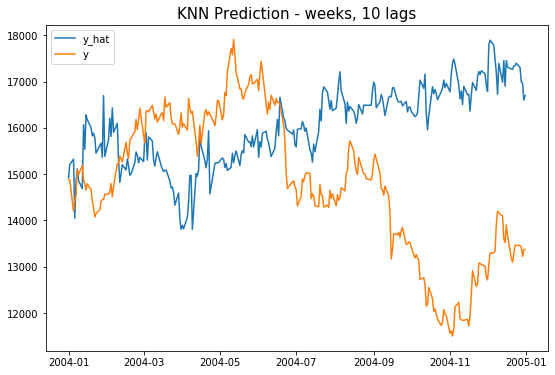

{'1': 1971.846306278373, '2': 1990.1314177168879, '3': 2017.7355301078792, '4': 2103.286353541897, '5': 2052.507215200683, '6': 2053.270834869709, '7': 2071.357068371575}


In [55]:
from sklearn import neighbors

cv_results = {}

for K in range(7):
    K = K+1
    regressor = neighbors.KNeighborsRegressor(n_neighbors=K)

    print()
    print('K: ', K)
    
    regressor.fit(X_train, y_train)
    #print(regressor.coef_)

    y_pred = regressor.predict(X_test)
    y_pred = pd.Series(y_pred)
    y_pred.index = y_test.index


    original_tail = LME_shifted.loc[y_train.index[-window_setting:]]

    for key, item in y_pred.items():
        rolling_avg = original_tail.tail(window_setting).mean()
        unscaled_result = item+rolling_avg
        original_tail = original_tail.append(pd.Series([unscaled_result]))

    unscaled = pd.Series(original_tail)
    unscaled = unscaled[window_setting:]
    unscaled.index = y_test.index


    original_tail = LME_shifted.loc[y_train.index[-window_setting:]]

    for key, item in y_test.items():
        rolling_avg = original_tail.tail(window_setting).mean()
        original_y = item+rolling_avg
        original_tail = original_tail.append(pd.Series([original_y]))


    original_y = pd.Series(original_tail)
    original_y = original_y[window_setting:]
    original_y.index = y_test.index
    
    
    print('Mean Absolute Error:', metrics.mean_absolute_error(original_y, unscaled))  
    print('Mean Squared Error:', metrics.mean_squared_error(original_y, unscaled))  
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(original_y, unscaled)))

    
    mae = metrics.mean_absolute_error(original_y, unscaled)

    #print('kfold test accuracy =', kfold_test_accuracy)
    cv_results[str(K)] = mae

    # To find the best/optimal parameters


    
plt.plot(unscaled)
plt.plot(original_y)
plt.legend(['y_hat', 'y'])
plt.title('KNN Prediction - weeks, 10 lags', fontsize=15)

plt.show()

print(cv_results)

ds
2004-01-01    14877.0
2004-01-02    14877.0
2004-01-05    14201.0
2004-01-06    14423.0
2004-01-07    14550.0
dtype: float64
ds
2001-01-29    6040.0
2001-01-30    6090.0
2001-01-31    5958.0
2001-02-01    6054.0
2001-02-02    6116.0
dtype: float64


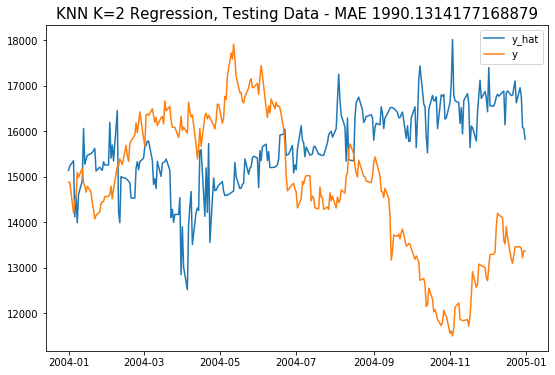

Mean Absolute Error: 1990.1314177168879
Mean Squared Error: 5720275.312136189
Root Mean Squared Error: 2391.709704821258


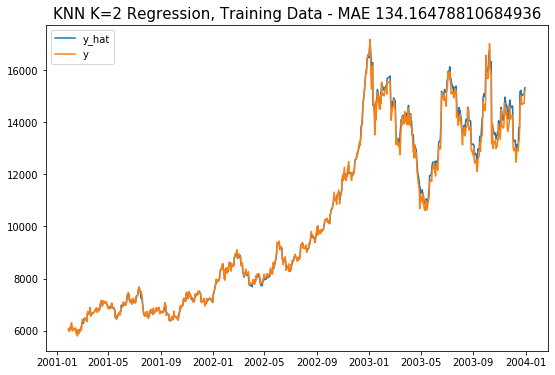

Mean Absolute Error: 134.16478810684936
Mean Squared Error: 40390.25152609091
Root Mean Squared Error: 200.97326072413443


In [56]:
K = 2
regressor = neighbors.KNeighborsRegressor(n_neighbors=K)
regressor.fit(X_train, y_train)

y_pred_train  = regressor.predict(X_train)
y_pred_train = pd.Series(y_pred_train)
y_pred_train.index = y_train.index

y_pred = regressor.predict(X_test)
y_pred = pd.Series(y_pred)
y_pred.index = y_test.index

LME_shifted = LME.shift(-261).dropna()

original_tail = LME_shifted.loc[y_train.index[-window_setting:]]
unscaled = unscale(y_pred, original_tail, window_setting)
unscaled.index = y_test.index


original_y = unscale(y_test, original_tail, window_setting)
original_y.index = y_test.index
print(original_y.head())

###############

original_tail_train = LME_shifted.loc[y_train.index[:window_setting]]

original_y_train = unscale(y_train.iloc[window_setting:], original_tail_train, window_setting)
original_y_train.index = y_train[window_setting:].index

y_pred_train_unscaled = unscale(y_pred_train.iloc[window_setting:], original_tail_train, window_setting)
y_pred_train_unscaled.index = y_train[window_setting:].index

print(original_y_train.head())

###########

plt.plot(unscaled)
plt.plot(original_y)
plt.legend(['y_hat', 'y'])
plt.title('KNN K=' +str(K) +' Regression, Testing Data - MAE ' + str(metrics.mean_absolute_error(original_y, unscaled)), fontsize=15)
filename = 'results/KNN_' + 'window_'+ str(window_setting) + 'lag_'+str(lag_length)+'_test.png'
#plt.savefig(filename)
plt.show()

print('Mean Absolute Error:', metrics.mean_absolute_error(original_y, unscaled))  
print('Mean Squared Error:', metrics.mean_squared_error(original_y, unscaled))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(original_y, unscaled)))

results = pd.DataFrame({'y_test': original_y, 'y_pred_unscaled': unscaled})
results['error'] = results['y_test'] - results['y_pred_unscaled']
 


plt.plot(y_pred_train_unscaled)
plt.plot(original_y_train)
plt.legend(['y_hat', 'y'])
plt.title('KNN K=' +str(K)+' Regression, Training Data - MAE '+ str(metrics.mean_absolute_error(original_y_train, y_pred_train_unscaled)), fontsize=15)
filename = 'results/KNN_' + 'window_'+ str(window_setting) + 'lag_'+str(lag_length)+'_train.png'

#plt.savefig(filename)
plt.show()

print('Mean Absolute Error:', metrics.mean_absolute_error(original_y_train, y_pred_train_unscaled))  
print('Mean Squared Error:', metrics.mean_squared_error(original_y_train, y_pred_train_unscaled))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(original_y_train, y_pred_train_unscaled)))



{'learning_rate': 0.0001, 'n_estimators': 50}
Mean Absolute Error: 2860.58147112579
Mean Squared Error: 13082665.576052396
Root Mean Squared Error: 3616.996761963217

{'learning_rate': 0.0001, 'n_estimators': 100}
Mean Absolute Error: 2994.669151259048
Mean Squared Error: 14386880.681054164
Root Mean Squared Error: 3793.0041762505566

{'learning_rate': 0.0001, 'n_estimators': 150}
Mean Absolute Error: 2966.5535228373183
Mean Squared Error: 14063768.600439781
Root Mean Squared Error: 3750.1691429107277

{'learning_rate': 0.0001, 'n_estimators': 200}
Mean Absolute Error: 2966.817454563528
Mean Squared Error: 14160243.316986373
Root Mean Squared Error: 3763.0098746862695

{'learning_rate': 0.0001, 'n_estimators': 250}
Mean Absolute Error: 2981.6895769733146
Mean Squared Error: 14347269.684195023
Root Mean Squared Error: 3787.7789909384924

{'learning_rate': 0.0001, 'n_estimators': 300}
Mean Absolute Error: 2941.686115686489
Mean Squared Error: 13881746.777272878
Root Mean Squared Error: 

Mean Absolute Error: 3255.732888307099
Mean Squared Error: 18121553.76783493
Root Mean Squared Error: 4256.941832799097

{'learning_rate': 0.3, 'n_estimators': 300}
Mean Absolute Error: 3297.410923300642
Mean Squared Error: 18600671.811399538
Root Mean Squared Error: 4312.8496161354315

{'learning_rate': 0.3, 'n_estimators': 350}
Mean Absolute Error: 3271.7936317472095
Mean Squared Error: 18298073.960367523
Root Mean Squared Error: 4277.62480359925

{'learning_rate': 0.3, 'n_estimators': 400}
Mean Absolute Error: 3266.230885049437
Mean Squared Error: 18202155.108719155
Root Mean Squared Error: 4266.398376701261

{'learning_rate': 0.3, 'n_estimators': 450}
Mean Absolute Error: 3291.0340477942664
Mean Squared Error: 18598863.35552997
Root Mean Squared Error: 4312.639951993439

Adaboost CV Results
{'learning_rate': 0.0001, 'n_estimators': 50} 2860.58147112579
{'learning_rate': 0.0001, 'n_estimators': 100} 2994.669151259048
{'learning_rate': 0.0001, 'n_estimators': 150} 2966.5535228373183


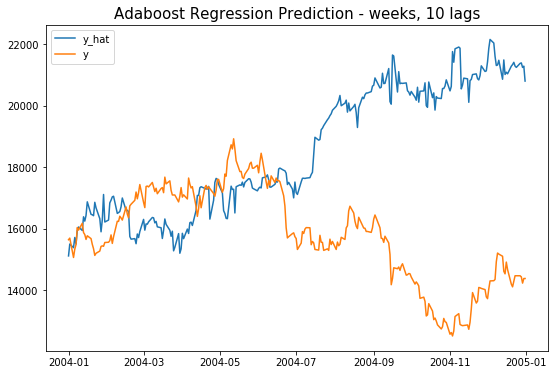

In [57]:
from sklearn.ensemble import AdaBoostRegressor

params1= ParameterGrid({'n_estimators' : [50, 100, 150, 200, 250, 300, 350, 400, 450],
                            'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]})

cv_results = {}

for params in params1:

    regressor = AdaBoostRegressor(**params, random_state=1)


    print()
    print(params)
    
    regressor.fit(X_train, y_train)
    #print(regressor.coef_)

    y_pred = regressor.predict(X_test)
    y_pred = pd.Series(y_pred)
    y_pred.index = y_test.index
    # y_pred = y_pred.reindex(X_test.index)


    original_tail = LME.loc[y_train.index[-window_setting:]]

    for key, item in y_pred.items():
        rolling_avg = original_tail.tail(window_setting).mean()
        unscaled_result = item + rolling_avg
        original_tail = original_tail.append(pd.Series([unscaled_result]))

    unscaled = pd.Series(original_tail)
    unscaled = unscaled[window_setting:]
    unscaled.index = y_test.index


    original_tail = LME.loc[y_train.index[-window_setting:]]

    for key, item in y_test.items():
        rolling_avg = original_tail.tail(window_setting).mean()
        original_y = item + rolling_avg
        original_tail = original_tail.append(pd.Series([original_y]))


    original_y = pd.Series(original_tail)
    original_y = original_y[window_setting:]
    original_y.index = y_test.index
    
    
    print('Mean Absolute Error:', metrics.mean_absolute_error(original_y, unscaled))  
    print('Mean Squared Error:', metrics.mean_squared_error(original_y, unscaled))  
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(original_y, unscaled)))

    
    mae = metrics.mean_absolute_error(original_y, unscaled)

    #print('kfold test accuracy =', kfold_test_accuracy)
    cv_results[str(params)] = mae

    # To find the best/optimal parameters

    '''Calculates maximum test accuracy value and parameters'''
    #min_test_accuracy, min_parameters = 0, 0
    min_test_accuracy = 3000
    for key, value in cv_results.items():
        if value < min_test_accuracy:
            min_test_accuracy = value
            min_parameters = key
            
print()
print('Adaboost CV Results')
for key, value in cv_results.items():
    print(key, value)

print()
print('Best Results:')
if min_test_accuracy==3000:
    print('error')
else:
    print('Minimum Test Accuracy: ', min_test_accuracy)
print('Best Parameters: ', min_parameters)
print()

plt.plot(unscaled)
plt.plot(original_y)
plt.legend(['y_hat', 'y'])
plt.title('Adaboost Regression Prediction - weeks, 10 lags', fontsize=15)

plt.show()
    
    
    

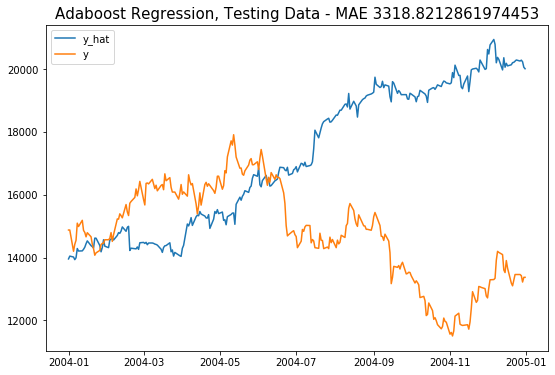

Mean Absolute Error: 3318.8212861974453
Mean Squared Error: 17958999.236988574
Root Mean Squared Error: 4237.805946122188


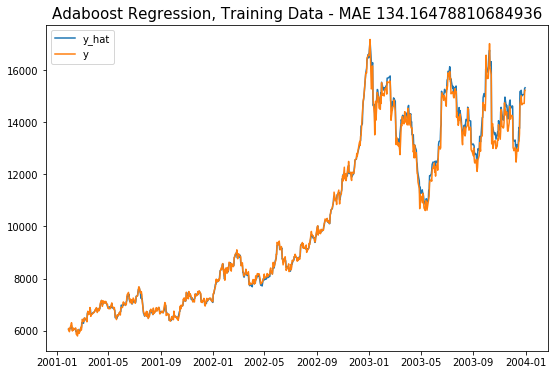

Mean Absolute Error: 134.16478810684936
Mean Squared Error: 40390.25152609091
Root Mean Squared Error: 200.97326072413443


In [58]:
regressor = AdaBoostRegressor(learning_rate=0.1, n_estimators=50, random_state=1)

regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)
y_pred = pd.Series(y_pred)
y_pred.index = y_test.index

original_tail = LME_shifted.loc[y_train.index[-window_setting:]]
unscaled = unscale(y_pred, original_tail, window_setting)
unscaled.index = y_test.index


original_y = unscale(y_test, original_tail, window_setting)
original_y.index = y_test.index
#print(original_y.head())

###############

original_tail_train = LME_shifted.loc[y_train.index[:window_setting]]

original_y_train = unscale(y_train.iloc[window_setting:], original_tail_train, window_setting)
original_y_train.index = y_train[window_setting:].index

y_pred_train_unscaled = unscale(y_pred_train.iloc[window_setting:], original_tail_train, window_setting)
y_pred_train_unscaled.index = y_train[window_setting:].index

#print(original_y_train.head())

###########

plt.plot(unscaled)
plt.plot(original_y)
plt.legend(['y_hat', 'y'])
plt.title('Adaboost Regression, Testing Data - MAE ' + str(metrics.mean_absolute_error(original_y, unscaled)), fontsize=15)
filename = 'results/adaboost_' + 'window_'+ str(window_setting) + 'lag_'+str(lag_length)+'_test.png'
#plt.savefig(filename)
plt.show()

print('Mean Absolute Error:', metrics.mean_absolute_error(original_y, unscaled))  
print('Mean Squared Error:', metrics.mean_squared_error(original_y, unscaled))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(original_y, unscaled)))

results = pd.DataFrame({'y_test': original_y, 'y_pred_unscaled': unscaled})
results['error'] = results['y_test'] - results['y_pred_unscaled']



plt.plot(y_pred_train_unscaled)
plt.plot(original_y_train)
plt.legend(['y_hat', 'y'])
plt.title('Adaboost Regression, Training Data - MAE '+ str(metrics.mean_absolute_error(original_y_train, y_pred_train_unscaled)), fontsize=15)
filename = 'results/adaboost_' + 'window_'+ str(window_setting) + 'lag_'+str(lag_length)+'_train.png'

#plt.savefig(filename)
plt.show()

print('Mean Absolute Error:', metrics.mean_absolute_error(original_y_train, y_pred_train_unscaled))  
print('Mean Squared Error:', metrics.mean_squared_error(original_y_train, y_pred_train_unscaled))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(original_y_train, y_pred_train_unscaled)))


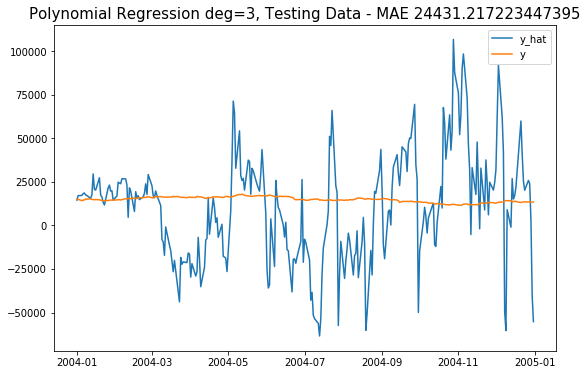

Mean Absolute Error: 24431.217223447395
Mean Squared Error: 1015987090.2631657
Root Mean Squared Error: 31874.552393142178


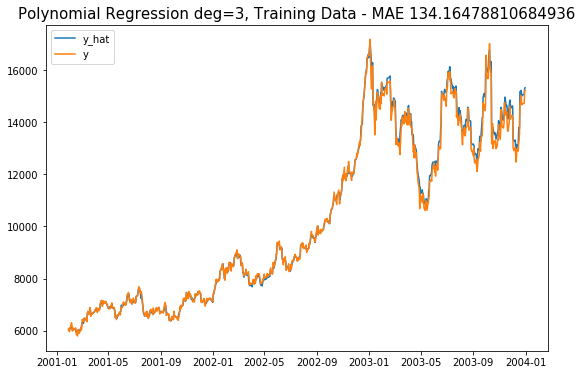

Mean Absolute Error: 134.16478810684936
Mean Squared Error: 40390.25152609091
Root Mean Squared Error: 200.97326072413443


In [60]:
polynomial_features= PolynomialFeatures(degree=3)

X_poly = polynomial_features.fit_transform(X_train)

regressor = LinearRegression()
regressor.fit(X_poly, y_train)

X_poly_test = polynomial_features.fit_transform(X_test)
y_poly_pred = regressor.predict(X_poly_test)
y_poly_pred = pd.Series(y_poly_pred)
y_poly_pred.index = y_test.index

y_pred = y_poly_pred


X_poly_train = polynomial_features.fit_transform(X_train)
y_poly_pred = regressor.predict(X_poly_train)
y_poly_pred = pd.Series(y_poly_pred)
y_poly_pred.index = y_train.index

y_pred_train_unscaled = y_poly_pred


##############

original_tail = LME_shifted.loc[y_train.index[-window_setting:]]
unscaled = unscale(y_pred, original_tail, window_setting)
unscaled.index = y_test.index


original_y = unscale(y_test, original_tail, window_setting)
original_y.index = y_test.index
#print(original_y.head())

###############

original_tail_train = LME_shifted.loc[y_train.index[:window_setting]]

original_y_train = unscale(y_train.iloc[window_setting:], original_tail_train, window_setting)
original_y_train.index = y_train[window_setting:].index

y_pred_train_unscaled = unscale(y_pred_train.iloc[window_setting:], original_tail_train, window_setting)
y_pred_train_unscaled.index = y_train[window_setting:].index

#print(original_y_train.head())

###########

plt.plot(unscaled)
plt.plot(original_y)
plt.legend(['y_hat', 'y'])
plt.title('Polynomial Regression deg=3, Testing Data - MAE ' + str(metrics.mean_absolute_error(original_y, unscaled)), fontsize=15)
filename = 'results/polynomial_' + 'window_'+ str(window_setting) + 'lag_'+str(lag_length)+'_test.png'
#plt.savefig(filename)
plt.show()

print('Mean Absolute Error:', metrics.mean_absolute_error(original_y, unscaled))  
print('Mean Squared Error:', metrics.mean_squared_error(original_y, unscaled))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(original_y, unscaled)))

results = pd.DataFrame({'y_test': original_y, 'y_pred_unscaled': unscaled})
results['error'] = results['y_test'] - results['y_pred_unscaled']



plt.plot(y_pred_train_unscaled)
plt.plot(original_y_train)
plt.legend(['y_hat', 'y'])
plt.title('Polynomial Regression deg=3, Training Data - MAE '+ str(metrics.mean_absolute_error(original_y_train, y_pred_train_unscaled)), fontsize=15)
filename = 'results/polynomial_' + 'window_'+ str(window_setting) + 'lag_'+str(lag_length)+'_train.png'

#plt.savefig(filename)
plt.show()

print('Mean Absolute Error:', metrics.mean_absolute_error(original_y_train, y_pred_train_unscaled))  
print('Mean Squared Error:', metrics.mean_squared_error(original_y_train, y_pred_train_unscaled))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(original_y_train, y_pred_train_unscaled)))






{'alpha': 1e-05}
Mean Absolute Error: 3604.6704820935724
Mean Squared Error: 18445475.230753116
Root Mean Squared Error: 4294.819580698719

{'alpha': 0.0001}
Mean Absolute Error: 3604.6704775591547
Mean Squared Error: 18445475.180746377
Root Mean Squared Error: 4294.819574876968

{'alpha': 0.001}
Mean Absolute Error: 3604.670431939005
Mean Squared Error: 18445474.67722607
Root Mean Squared Error: 4294.819516257473

{'alpha': 0.01}
Mean Absolute Error: 3604.6699760552374
Mean Squared Error: 18445469.64178186
Root Mean Squared Error: 4294.818930034404

{'alpha': 0.1}
Mean Absolute Error: 3604.6654239069308
Mean Squared Error: 18445419.36750844
Root Mean Squared Error: 4294.813077132512

{'alpha': 1}
Mean Absolute Error: 3604.6198541310973
Mean Squared Error: 18444915.763689008
Root Mean Squared Error: 4294.75444742642

Ridge CV Results
{'alpha': 1e-05} 3604.6704820935724
{'alpha': 0.0001} 3604.6704775591547
{'alpha': 0.001} 3604.670431939005
{'alpha': 0.01} 3604.6699760552374
{'alpha': 

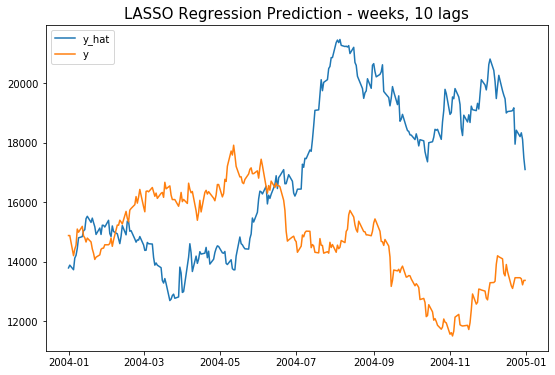

In [61]:
from sklearn import linear_model

params1= ParameterGrid({'alpha' : [ .00001 ,.0001, .001, .01, .1, 1]
                            })

cv_results = {}

for params in params1:

    regressor = linear_model.Lasso(**params, random_state=1)

    print()
    print(params)
    
    regressor.fit(X_train, y_train)
    #print(regressor.coef_)

    y_pred = regressor.predict(X_test)
    y_pred = pd.Series(y_pred)
    y_pred.index = y_test.index
    # y_pred = y_pred.reindex(X_test.index)

    original_tail = LME_shifted.loc[y_train.index[-window_setting:]]

    for key, item in y_pred.items():
        rolling_avg = original_tail.tail(window_setting).mean()
        unscaled_result = item + rolling_avg
        original_tail = original_tail.append(pd.Series([unscaled_result]))

    unscaled = pd.Series(original_tail)
    unscaled = unscaled[window_setting:]
    unscaled.index = y_test.index


    original_tail = LME_shifted.loc[y_train.index[-window_setting:]]

    for key, item in y_test.items():
        rolling_avg = original_tail.tail(window_setting).mean()
        original_y = item + rolling_avg
        original_tail = original_tail.append(pd.Series([original_y]))


    original_y = pd.Series(original_tail)
    original_y = original_y[window_setting:]
    original_y.index = y_test.index
    
    
    print('Mean Absolute Error:', metrics.mean_absolute_error(original_y, unscaled))  
    print('Mean Squared Error:', metrics.mean_squared_error(original_y, unscaled))  
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(original_y, unscaled)))

    
    mae = metrics.mean_absolute_error(original_y, unscaled)

    #print('kfold test accuracy =', kfold_test_accuracy)
    cv_results[str(params)] = mae

    # To find the best/optimal parameters

    '''Calculates maximum test accuracy value and parameters'''
    #min_test_accuracy, min_parameters = 0, 0
    min_test_accuracy = 3000
    for key, value in cv_results.items():
        if value < min_test_accuracy:
            min_test_accuracy = value
            min_parameters = key
            
print()
print('Ridge CV Results')
for key, value in cv_results.items():
    print(key, value)

print()
print('Best Results:')
if min_test_accuracy==3000:
    print('error')
else:
    print('Minimum Test MAE: ', min_test_accuracy)
print('Best Parameters: ', min_parameters)
print()

plt.plot(unscaled)
plt.plot(original_y)
plt.legend(['y_hat', 'y'])
plt.title('LASSO Regression Prediction - weeks, 10 lags', fontsize=15)

plt.show()


{'alpha': 1e-05}
Mean Absolute Error: 3604.6704820935724
Mean Squared Error: 18445475.230753116
Root Mean Squared Error: 4294.819580698719

{'alpha': 0.0001}
Mean Absolute Error: 3604.6704775591547
Mean Squared Error: 18445475.180746377
Root Mean Squared Error: 4294.819574876968

{'alpha': 0.001}
Mean Absolute Error: 3604.670431939005
Mean Squared Error: 18445474.67722607
Root Mean Squared Error: 4294.819516257473

{'alpha': 0.01}
Mean Absolute Error: 3604.6699760552374
Mean Squared Error: 18445469.64178186
Root Mean Squared Error: 4294.818930034404

{'alpha': 0.1}
Mean Absolute Error: 3604.6654239069308
Mean Squared Error: 18445419.36750844
Root Mean Squared Error: 4294.813077132512

{'alpha': 1}
Mean Absolute Error: 3604.6198541310973
Mean Squared Error: 18444915.763689008
Root Mean Squared Error: 4294.75444742642

Ridge CV Results
{'alpha': 1e-05} 3604.6704820935724
{'alpha': 0.0001} 3604.6704775591547
{'alpha': 0.001} 3604.670431939005
{'alpha': 0.01} 3604.6699760552374
{'alpha': 

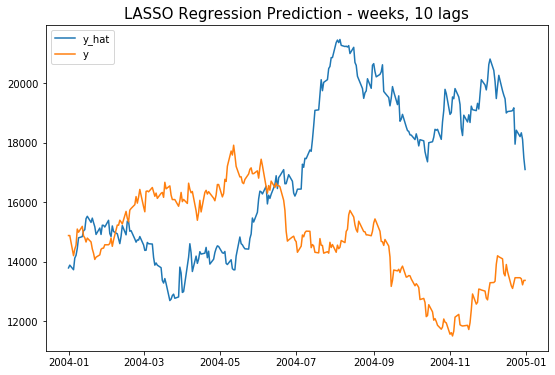

In [62]:
from sklearn import linear_model

params1= ParameterGrid({'alpha' : [ .00001 ,.0001, .001, .01, .1, 1]
                            })

cv_results = {}

for params in params1:

    regressor = linear_model.Lasso(**params, random_state=1)

    print()
    print(params)
    
    regressor.fit(X_train, y_train)
    #print(regressor.coef_)

    y_pred = regressor.predict(X_test)
    y_pred = pd.Series(y_pred)
    y_pred.index = y_test.index
    # y_pred = y_pred.reindex(X_test.index)

    original_tail = LME_shifted.loc[y_train.index[-window_setting:]]

    for key, item in y_pred.items():
        rolling_avg = original_tail.tail(window_setting).mean()
        unscaled_result = item + rolling_avg
        original_tail = original_tail.append(pd.Series([unscaled_result]))

    unscaled = pd.Series(original_tail)
    unscaled = unscaled[window_setting:]
    unscaled.index = y_test.index


    original_tail = LME_shifted.loc[y_train.index[-window_setting:]]

    for key, item in y_test.items():
        rolling_avg = original_tail.tail(window_setting).mean()
        original_y = item + rolling_avg
        original_tail = original_tail.append(pd.Series([original_y]))


    original_y = pd.Series(original_tail)
    original_y = original_y[window_setting:]
    original_y.index = y_test.index
    
    
    print('Mean Absolute Error:', metrics.mean_absolute_error(original_y, unscaled))  
    print('Mean Squared Error:', metrics.mean_squared_error(original_y, unscaled))  
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(original_y, unscaled)))

    
    mae = metrics.mean_absolute_error(original_y, unscaled)

    #print('kfold test accuracy =', kfold_test_accuracy)
    cv_results[str(params)] = mae

    # To find the best/optimal parameters

    '''Calculates maximum test accuracy value and parameters'''
    #min_test_accuracy, min_parameters = 0, 0
    min_test_accuracy = 3000
    for key, value in cv_results.items():
        if value < min_test_accuracy:
            min_test_accuracy = value
            min_parameters = key
            
print()
print('Ridge CV Results')
for key, value in cv_results.items():
    print(key, value)

print()
print('Best Results:')
if min_test_accuracy==3000:
    print('error')
else:
    print('Minimum Test MAE: ', min_test_accuracy)
print('Best Parameters: ', min_parameters)
print()

plt.plot(unscaled)
plt.plot(original_y)
plt.legend(['y_hat', 'y'])
plt.title('LASSO Regression Prediction - weeks, 10 lags', fontsize=15)

plt.show()

In [45]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true))*100

def root_mean_squared_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.sqrt(((y_pred - y_true) **2).mean())
    #return np.mean(np.abs((y_true - y_pred) / y_true))*100


In [47]:
print('mape', mean_absolute_percentage_error(cmp_df['y'], cmp_df['yhat']))

print('rmse', root_mean_squared_error(cmp_df['y'], cmp_df['yhat']))

mape 219.83967767924054
rmse 0.05529372373011725
